In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import h5py
import sys
import os
import tensorflow as tf


import obspy
import obspy.core as oc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import seaborn as sns

import datetime

In [8]:
pathNow = Path().parent.absolute()
print(pathNow)

e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli


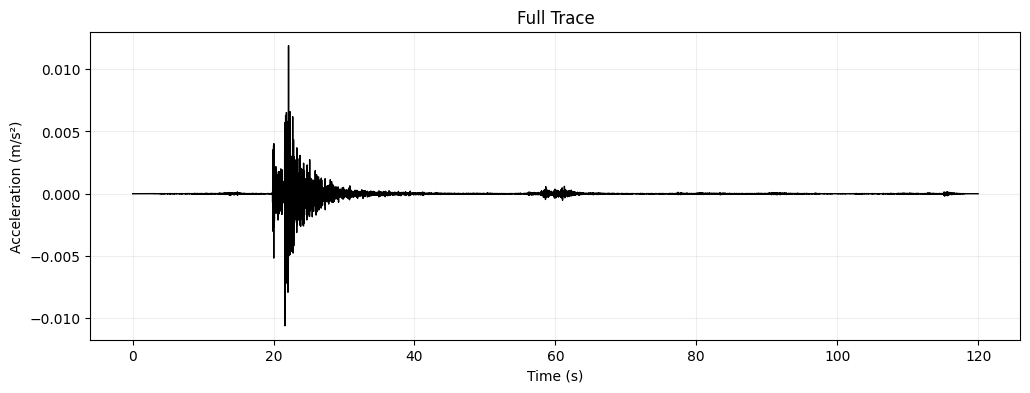

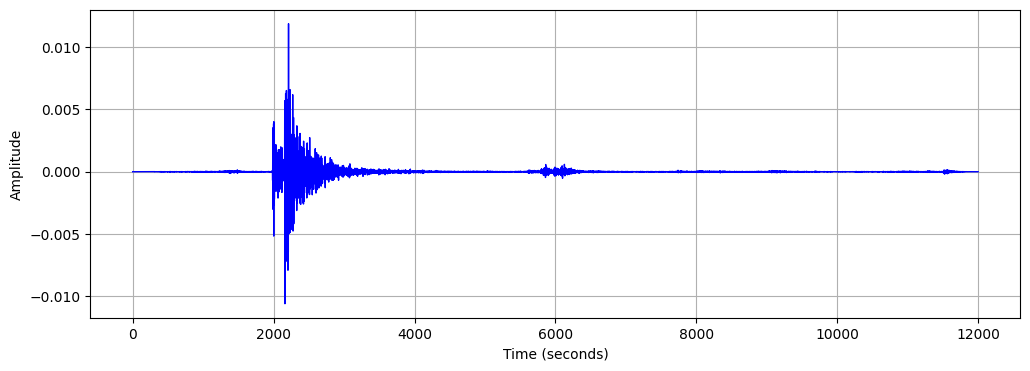

In [6]:
# Set up paths
base_folder = os.path.join(str(os.getcwd()))
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
model_folder = os.path.join(base_folder, 'model')
history_folder = os.path.join(base_folder, 'history')
evaluation_folder = os.path.join(base_folder, 'evaluation')

# Create directories
os.makedirs(model_folder, exist_ok=True)
os.makedirs(history_folder, exist_ok=True)
os.makedirs(evaluation_folder, exist_ok=True)

# Path to HDF5 file
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Get the metadata from HDF5
with h5py.File(hdf5_path, 'r') as f:
    metadata = f[f"event_0000/metadata"]
    full_trace = f[f"event_0000/full_trace"][:]
    sampling_rate = 100
    time_axis = np.linspace(0, len(full_trace)/sampling_rate, len(full_trace))

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, full_trace, 'k', linewidth=1.0)
    plt.title(f"Full Trace")
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(full_trace, 'b', linewidth=1.0)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

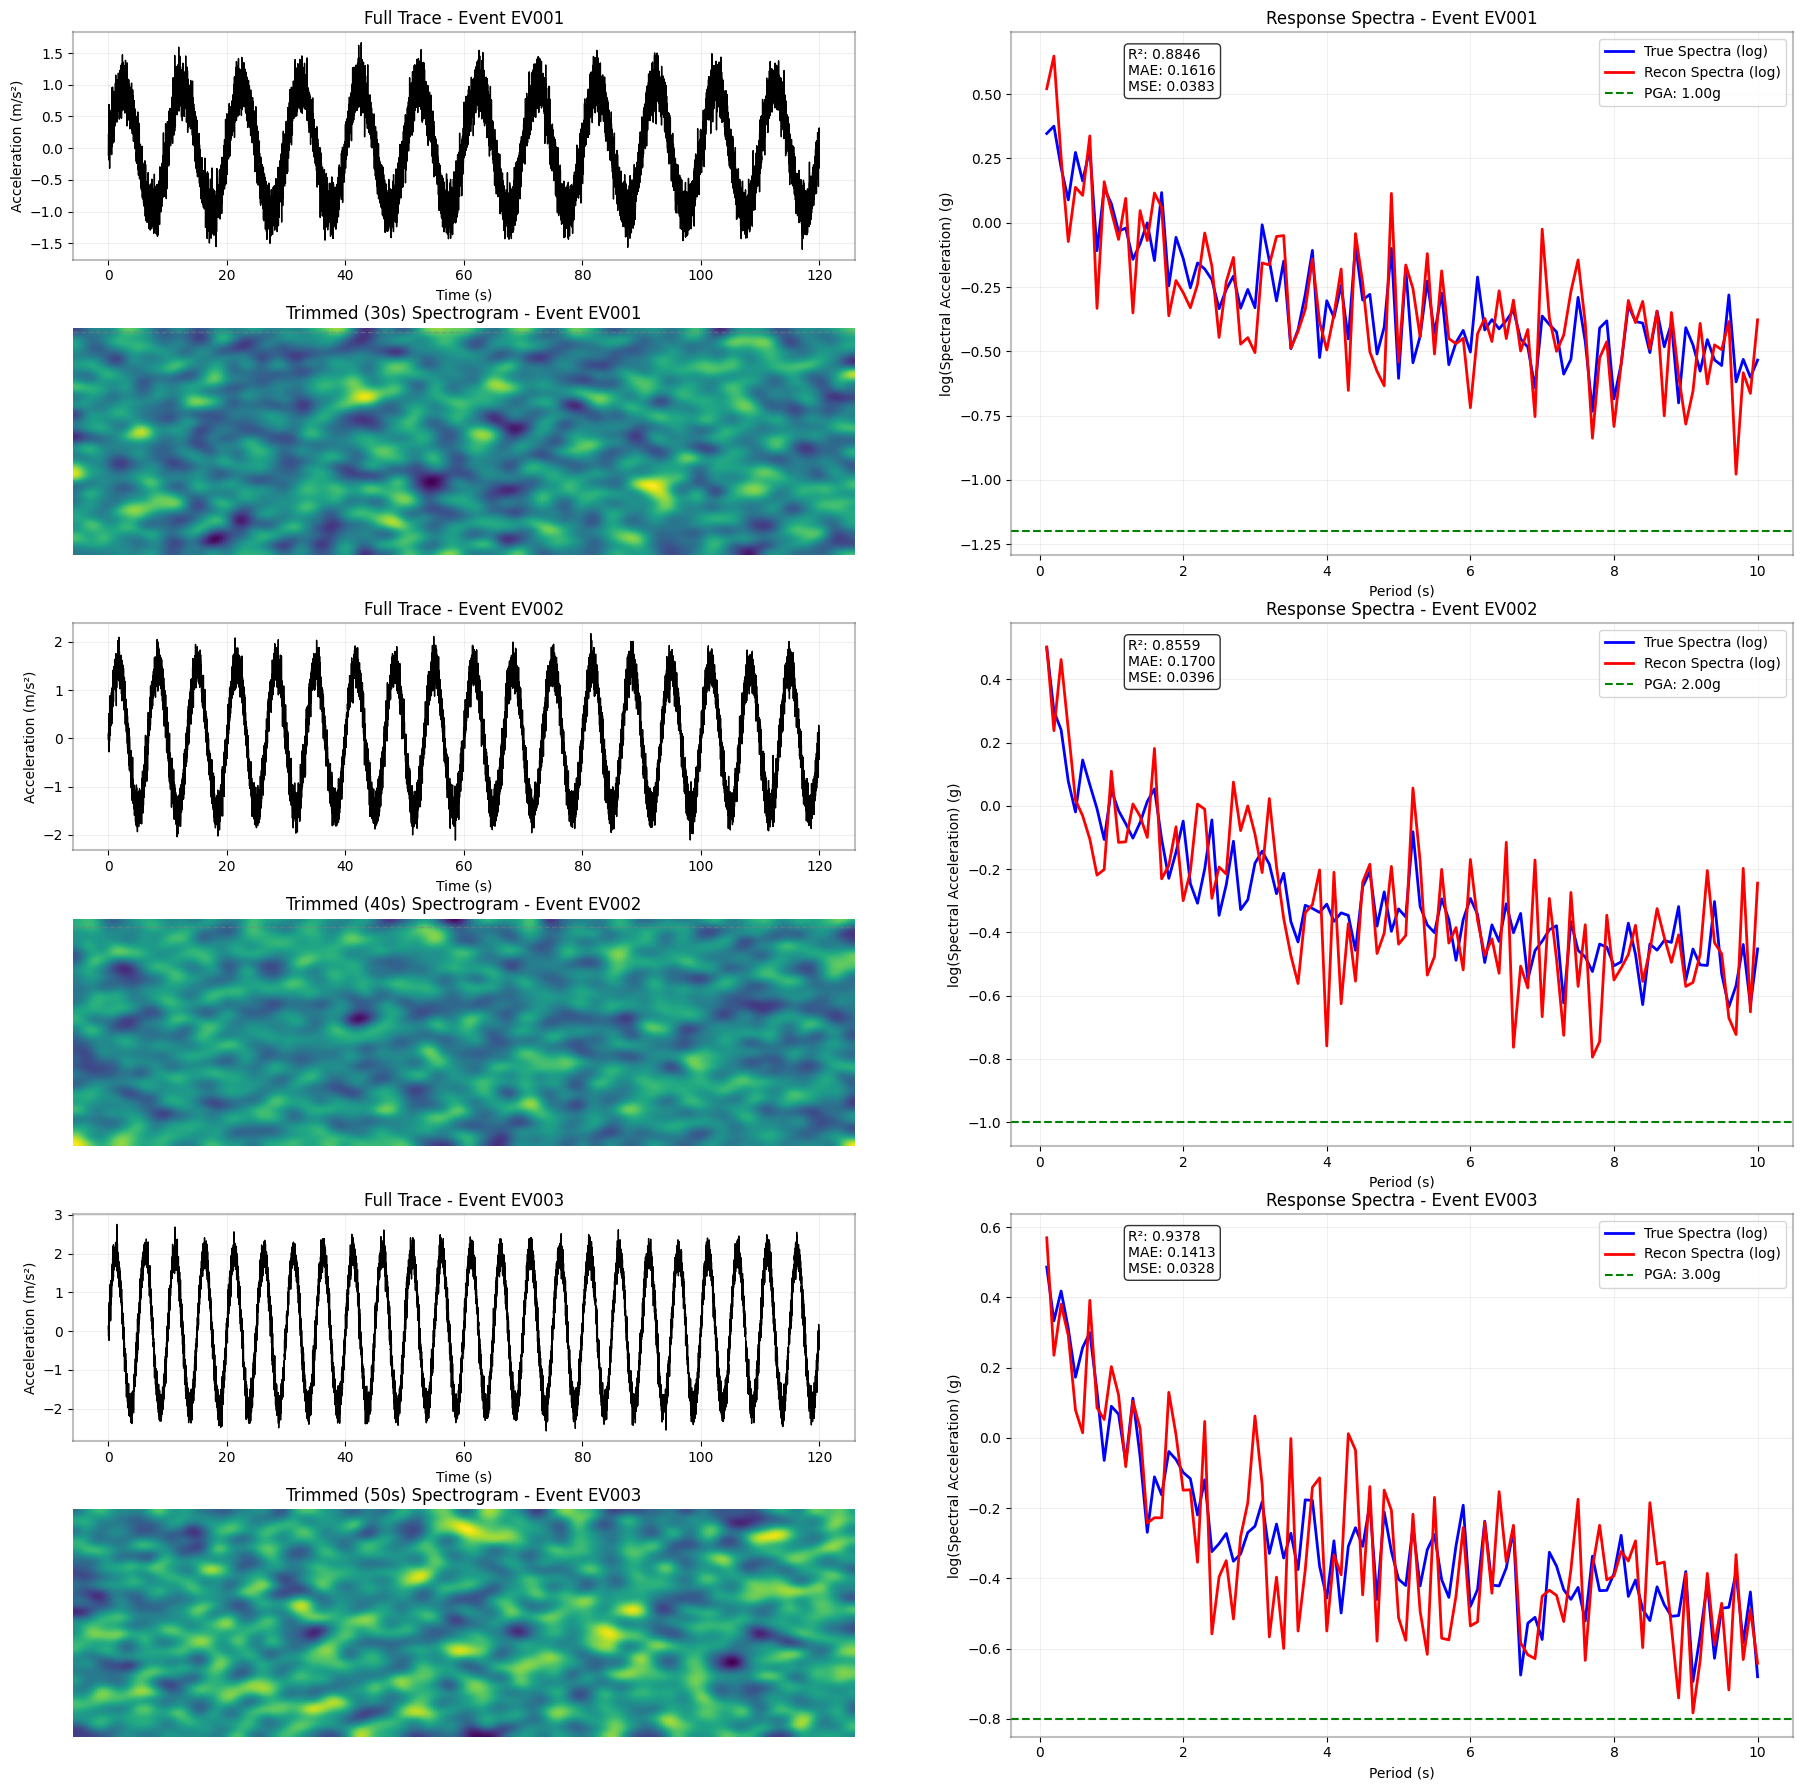

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

# Create dummy data
num_plot_samples = 3  # Number of events to plot

# Time series data
time_samples = 12000
time_axis = np.linspace(0, 120, time_samples)
dummy_events = []

for i in range(num_plot_samples):
    # Create a different waveform for each event
    noise = np.random.normal(0, 0.2, time_samples)
    freq = 0.1 + i * 0.05
    amplitude = 1 + i * 0.5
    full_trace = amplitude * np.sin(2 * np.pi * freq * time_axis) + noise
    
    # Create dummy spectrogram (colored noise image)
    img_size = (128, 256)
    img_array = np.random.rand(*img_size)
    
    # Smooth it to look more like a spectrogram
    from scipy.ndimage import gaussian_filter
    img_array = gaussian_filter(img_array, sigma=3)
    
    # Create dummy spectra data
    osc_periods = np.linspace(0.1, 10, 100)
    true_spectra_log = -0.5 * np.log10(osc_periods) + np.random.normal(0, 0.1, len(osc_periods))
    pred_spectra_log = true_spectra_log + np.random.normal(0, 0.15, len(osc_periods))
    
    # Create dummy metrics
    individual_r2 = 0.85 + np.random.random() * 0.1
    individual_mae = 0.12 + np.random.random() * 0.05
    individual_mse = 0.03 + np.random.random() * 0.01
    
    # Store all for this event
    dummy_events.append({
        'event_id': f"EV{i+1:03d}",
        'full_trace': full_trace,
        'img_array': img_array,
        'osc_periods': osc_periods,
        'true_spectra_log': true_spectra_log,
        'pred_spectra_log': pred_spectra_log,
        'individual_r2': individual_r2,
        'individual_mae': individual_mae,
        'individual_mse': individual_mse,
        'trim_time': f"{30 + i*10}s",
        'pga_value': -1.2 + i * 0.2,
        'pga_label': f"PGA: {i+1:.2f}g"
    })

# Create figure
plt.figure(figsize=(18, 6 * num_plot_samples))

# Create a GridSpec for more control over the layout
gs = gridspec.GridSpec(num_plot_samples * 2, 2, height_ratios=[1, 1] * num_plot_samples)

for plot_idx, event_data in enumerate(dummy_events):
    # Calculate the starting row for this event
    row_start = plot_idx * 2
    
    # Add a background rectangle to separate events
    if plot_idx > 0:
        plt.axhline(y=row_start, color='gray', linestyle='--', linewidth=1.0, alpha=0.5, xmin=0, xmax=1)
    
    # Extract event data
    event_id = event_data['event_id']
    full_trace = event_data['full_trace']
    img_array = event_data['img_array']
    osc_periods = event_data['osc_periods']
    true_spectra_log = event_data['true_spectra_log']
    pred_spectra_log = event_data['pred_spectra_log']
    individual_r2 = event_data['individual_r2']
    individual_mae = event_data['individual_mae']
    individual_mse = event_data['individual_mse']
    trim_time = event_data['trim_time']
    pga_value = event_data['pga_value']
    pga_label = event_data['pga_label']
    
    # Plot full waveform in top-left
    ax1 = plt.subplot(gs[row_start, 0])
    ax1.plot(time_axis, full_trace, 'k', linewidth=1.0)
    ax1.set_title(f"Full Trace - Event {event_id}")
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    
    # Plot response spectra in top-right (spanning 2 rows)
    ax2 = plt.subplot(gs[row_start:row_start+2, 1])
    ax2.plot(osc_periods, true_spectra_log, 'b', linewidth=2.0, label='True Spectra (log)')
    ax2.plot(osc_periods, pred_spectra_log, 'r', linewidth=2.0, label='Recon Spectra (log)')
    
    # Add metrics as text box
    metrics_text = f"R²: {individual_r2:.4f}\nMAE: {individual_mae:.4f}\nMSE: {individual_mse:.4f}"
    ax2.text(0.15, 0.97, metrics_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add PGA as horizontal line if available
    ax2.axhline(y=pga_value, color='g', linestyle='--', label=pga_label)
    
    ax2.set_xlabel('Period (s)')
    ax2.set_ylabel('log(Spectral Acceleration) (g)')
    ax2.set_title(f"Response Spectra - Event {event_id}")
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    ax2.legend()
    
    # Plot spectrogram in bottom-left
    ax3 = plt.subplot(gs[row_start+1, 0])
    im = ax3.imshow(img_array, aspect='auto', cmap='viridis')
    ax3.set_title(f"Trimmed ({trim_time}) Spectrogram - Event {event_id}")
    ax3.axis('off')
    
    # Add a box around the event
    for ax in [ax1, ax2, ax3]:
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_edgecolor('gray')
            spine.set_alpha(0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

## 2 Seconds

In [7]:
from metrics import R2Score, MAEMetric, MSEMetric
from preprocessing import SeismicDataGenerator, check_dataset_integrity
from vae_model import Sampling, SpectrogramVAE, train_vae, evaluate_vae

# === Configuration parameters ===
trim_time = "2s"  # Change to 2s, 25s, or 3s
batch_size = 16
epochs = 20
latent_dim = 256

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
model_folder = os.path.join(base_folder, 'model')
history_folder = os.path.join(base_folder, 'history')
evaluation_folder = os.path.join(base_folder, 'evaluation')

# Create directories
os.makedirs(model_folder, exist_ok=True)
os.makedirs(history_folder, exist_ok=True)
os.makedirs(evaluation_folder, exist_ok=True)

# Path to HDF5 file
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Print configuration
print(f"=== Configuration ===")
print(f"Trim time: {trim_time}")
print(f"Image folder: {os.path.join(images_folder, f'trimmed_{trim_time}')}")
print(f"Model will be saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history will be saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")
print(f"Evaluation results will be saved to: {os.path.join(evaluation_folder, f'vae_evaluation_{trim_time}.xlsx')}")
print(f"====================")

# Set memory growth for GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth set to True for GPU")
else:
    print("No GPU found, using CPU")

# Check dataset integrity for the specified trim time
print(f"Checking dataset integrity for trim time {trim_time}...")
found_files, missing_files = check_dataset_integrity(hdf5_path, images_folder, trim_time="2s")

# # Validate log data
# print("Validating logarithmic data...")
# validate_log_data(hdf5_path)

# Train the VAE model
print(f"Starting VAE model training for trim time {trim_time}...")
vae, history, test_indices = train_vae(
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    base_folder=base_folder,
    model_folder=model_folder,
    history_folder=history_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    epochs=epochs,
    batch_size=batch_size,
    latent_dim=latent_dim,
)

# Evaluate the model
print(f"Evaluating model for trim time {trim_time}...")
metrics = evaluate_vae(
    vae=vae,
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    num_plot_samples=4,
    eval_indices=test_indices
)
print("--------------------------------------------------------------------------------------")
print("Training and evaluation complete!")
print(f"Model saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")


# Display metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


=== Configuration ===
Trim time: 2s
Image folder: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_2s
Model will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_2s
Training history will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\history\vae_history_2s.csv
Evaluation results will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\evaluation\vae_evaluation_2s.xlsx
Found 1 GPU(s)
Memory growth set to True for GPU
Checking dataset integrity for trim time 2s...

===== DATASET INTEGRITY CHECK (trimmed_2s) =====
Checked 1000/16630 files...
Checked 2000/16630 files...
Checked 3000/16630 files...
Checked 4000/16630 files...
Checked 5000/16630 files...
Checked 6000/16630 files...
Checked 7000/16630 files...
Checked 8000/16630 files...
Checked 9000/16630 files...
Checked 10000/16630 files...
Checked 11000/16630 files...
Checked 12000/1663

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 679s 867ms/step - loss: 1.2497 - reconstruction_loss: 0.3034 - kl_loss: 3.7185 - r2_score: -0.4371 - mae: 0.3034 - mse: 0.1388 - val_loss: 0.1339 - val_reconstruction_loss: 0.0528 - val_kl_loss: 0.8105 - val_r2_score: 0.4530 - val_mae: 0.1851 - val_mse: 0.0528 - lr: 1.0000e-04
Epoch 2/20
780/780 [==============================] - ETA: 0s - loss: 0.3449 - reconstruction_loss: 0.1376 - kl_loss: 1.3568 - r2_score: 0.6269 - mae: 0.1376 - mse: 0.0360

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 1098s 1s/step - loss: 0.3448 - reconstruction_loss: 0.1376 - kl_loss: 1.3568 - r2_score: 0.6269 - mae: 0.1376 - mse: 0.0360 - val_loss: 0.0484 - val_reconstruction_loss: 0.0078 - val_kl_loss: 0.4051 - val_r2_score: 0.9187 - val_mae: 0.0650 - val_mse: 0.0078 - lr: 1.0000e-04
Epoch 3/20
780/780 [==============================] - 1014s 1s/step - loss: 0.1616 - reconstruction_loss: 0.0744 - kl_loss: 0.7408 - r2_score: 0.8942 - mae: 0.0744 - mse: 0.0102 - val_loss: 0.0591 - val_reconstruction_loss: 0.0068 - val_kl_loss: 0.5230 - val_r2_score: 0.9300 - val_mae: 0.0579 - val_mse: 0.0068 - lr: 1.0000e-04
Epoch 4/20
780/780 [==============================] - ETA: 0s - loss: 0.1065 - reconstruction_loss: 0.0655 - kl_loss: 0.2549 - r2_score: 0.9150 - mae: 0.0655 - mse: 0.0082

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 550s 705ms/step - loss: 0.1065 - reconstruction_loss: 0.0655 - kl_loss: 0.2549 - r2_score: 0.9150 - mae: 0.0655 - mse: 0.0082 - val_loss: 0.0092 - val_reconstruction_loss: 0.0062 - val_kl_loss: 0.0302 - val_r2_score: 0.9360 - val_mae: 0.0544 - val_mse: 0.0062 - lr: 1.0000e-04
Epoch 5/20
780/780 [==============================] - 388s 498ms/step - loss: 0.0700 - reconstruction_loss: 0.0611 - kl_loss: 0.0850 - r2_score: 0.9241 - mae: 0.0611 - mse: 0.0073 - val_loss: 0.0101 - val_reconstruction_loss: 0.0059 - val_kl_loss: 0.0414 - val_r2_score: 0.9385 - val_mae: 0.0528 - val_mse: 0.0059 - lr: 1.0000e-04
Epoch 6/20
780/780 [==============================] - ETA: 0s - loss: 0.0674 - reconstruction_loss: 0.0586 - kl_loss: 0.0645 - r2_score: 0.9291 - mae: 0.0586 - mse: 0.0068

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 621s 796ms/step - loss: 0.0674 - reconstruction_loss: 0.0586 - kl_loss: 0.0645 - r2_score: 0.9291 - mae: 0.0586 - mse: 0.0068 - val_loss: 0.0080 - val_reconstruction_loss: 0.0058 - val_kl_loss: 0.0216 - val_r2_score: 0.9400 - val_mae: 0.0518 - val_mse: 0.0058 - lr: 1.0000e-04
Epoch 7/20
780/780 [==============================] - 386s 495ms/step - loss: 0.0622 - reconstruction_loss: 0.0572 - kl_loss: 0.0560 - r2_score: 0.9318 - mae: 0.0572 - mse: 0.0066 - val_loss: 0.0084 - val_reconstruction_loss: 0.0057 - val_kl_loss: 0.0264 - val_r2_score: 0.9407 - val_mae: 0.0515 - val_mse: 0.0057 - lr: 1.0000e-04
Epoch 8/20
780/780 [==============================] - ETA: 0s - loss: 0.0595 - reconstruction_loss: 0.0561 - kl_loss: 0.0259 - r2_score: 0.9339 - mae: 0.0561 - mse: 0.0064

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 611s 783ms/step - loss: 0.0595 - reconstruction_loss: 0.0561 - kl_loss: 0.0259 - r2_score: 0.9339 - mae: 0.0561 - mse: 0.0064 - val_loss: 0.0068 - val_reconstruction_loss: 0.0057 - val_kl_loss: 0.0112 - val_r2_score: 0.9411 - val_mae: 0.0512 - val_mse: 0.0057 - lr: 1.0000e-04
Epoch 9/20
780/780 [==============================] - ETA: 0s - loss: 0.0582 - reconstruction_loss: 0.0553 - kl_loss: 0.0240 - r2_score: 0.9354 - mae: 0.0553 - mse: 0.0063

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 454s 582ms/step - loss: 0.0582 - reconstruction_loss: 0.0553 - kl_loss: 0.0240 - r2_score: 0.9354 - mae: 0.0553 - mse: 0.0063 - val_loss: 0.0064 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0077 - val_r2_score: 0.9415 - val_mae: 0.0508 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 10/20
780/780 [==============================] - ETA: 0s - loss: 0.0572 - reconstruction_loss: 0.0548 - kl_loss: 0.0200 - r2_score: 0.9364 - mae: 0.0548 - mse: 0.0061

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 807s 1s/step - loss: 0.0572 - reconstruction_loss: 0.0548 - kl_loss: 0.0200 - r2_score: 0.9364 - mae: 0.0548 - mse: 0.0061 - val_loss: 0.0061 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0051 - val_r2_score: 0.9417 - val_mae: 0.0507 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 11/20
780/780 [==============================] - 752s 964ms/step - loss: 0.0547 - reconstruction_loss: 0.0542 - kl_loss: 0.0108 - r2_score: 0.9373 - mae: 0.0542 - mse: 0.0061 - val_loss: 0.0065 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0092 - val_r2_score: 0.9421 - val_mae: 0.0506 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 12/20
780/780 [==============================] - ETA: 0s - loss: 0.0544 - reconstruction_loss: 0.0539 - kl_loss: 0.0062 - r2_score: 0.9378 - mae: 0.0539 - mse: 0.0060

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 561s 720ms/step - loss: 0.0544 - reconstruction_loss: 0.0539 - kl_loss: 0.0062 - r2_score: 0.9378 - mae: 0.0539 - mse: 0.0060 - val_loss: 0.0059 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0030 - val_r2_score: 0.9419 - val_mae: 0.0507 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 13/20
780/780 [==============================] - ETA: 0s - loss: 0.0543 - reconstruction_loss: 0.0535 - kl_loss: 0.0045 - r2_score: 0.9385 - mae: 0.0535 - mse: 0.0059

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 400s 513ms/step - loss: 0.0543 - reconstruction_loss: 0.0535 - kl_loss: 0.0045 - r2_score: 0.9385 - mae: 0.0535 - mse: 0.0059 - val_loss: 0.0057 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0014 - val_r2_score: 0.9419 - val_mae: 0.0505 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 14/20
780/780 [==============================] - ETA: 0s - loss: 0.0537 - reconstruction_loss: 0.0532 - kl_loss: 0.0027 - r2_score: 0.9389 - mae: 0.0532 - mse: 0.0059

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 820s 1s/step - loss: 0.0537 - reconstruction_loss: 0.0532 - kl_loss: 0.0027 - r2_score: 0.9389 - mae: 0.0532 - mse: 0.0059 - val_loss: 0.0057 - val_reconstruction_loss: 0.0056 - val_kl_loss: 8.1983e-04 - val_r2_score: 0.9417 - val_mae: 0.0506 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 15/20
780/780 [==============================] - ETA: 0s - loss: 0.0529 - reconstruction_loss: 0.0529 - kl_loss: 0.0019 - r2_score: 0.9395 - mae: 0.0529 - mse: 0.0058

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 680s 871ms/step - loss: 0.0529 - reconstruction_loss: 0.0529 - kl_loss: 0.0019 - r2_score: 0.9395 - mae: 0.0529 - mse: 0.0058 - val_loss: 0.0057 - val_reconstruction_loss: 0.0056 - val_kl_loss: 7.5320e-04 - val_r2_score: 0.9419 - val_mae: 0.0506 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 16/20
780/780 [==============================] - ETA: 0s - loss: 0.0531 - reconstruction_loss: 0.0527 - kl_loss: 0.0012 - r2_score: 0.9397 - mae: 0.0527 - mse: 0.0058

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 802s 1s/step - loss: 0.0531 - reconstruction_loss: 0.0527 - kl_loss: 0.0012 - r2_score: 0.9397 - mae: 0.0527 - mse: 0.0058 - val_loss: 0.0057 - val_reconstruction_loss: 0.0056 - val_kl_loss: 3.4067e-04 - val_r2_score: 0.9418 - val_mae: 0.0507 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 17/20
780/780 [==============================] - ETA: 0s - loss: 0.0527 - reconstruction_loss: 0.0526 - kl_loss: 7.2205e-04 - r2_score: 0.9401 - mae: 0.0526 - mse: 0.0058

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 737s 944ms/step - loss: 0.0527 - reconstruction_loss: 0.0526 - kl_loss: 7.2205e-04 - r2_score: 0.9401 - mae: 0.0526 - mse: 0.0058 - val_loss: 0.0056 - val_reconstruction_loss: 0.0056 - val_kl_loss: 2.3802e-04 - val_r2_score: 0.9422 - val_mae: 0.0505 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 18/20
780/780 [==============================] - ETA: 0s - loss: 0.0525 - reconstruction_loss: 0.0524 - kl_loss: 4.1850e-04 - r2_score: 0.9403 - mae: 0.0524 - mse: 0.0058

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 860s 1s/step - loss: 0.0525 - reconstruction_loss: 0.0524 - kl_loss: 4.1850e-04 - r2_score: 0.9403 - mae: 0.0524 - mse: 0.0058 - val_loss: 0.0056 - val_reconstruction_loss: 0.0056 - val_kl_loss: 2.4325e-04 - val_r2_score: 0.9424 - val_mae: 0.0504 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 19/20
780/780 [==============================] - 738s 945ms/step - loss: 0.0523 - reconstruction_loss: 0.0522 - kl_loss: 3.3832e-04 - r2_score: 0.9406 - mae: 0.0522 - mse: 0.0057 - val_loss: 0.0056 - val_reconstruction_loss: 0.0056 - val_kl_loss: 2.0641e-04 - val_r2_score: 0.9421 - val_mae: 0.0506 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 20/20
780/780 [==============================] - ETA: 0s - loss: 0.0522 - reconstruction_loss: 0.0521 - kl_loss: 2.9524e-04 - r2_score: 0.9408 - mae: 0.0521 - mse: 0.0057

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_2s\assets


780/780 [==============================] - 568s 727ms/step - loss: 0.0522 - reconstruction_loss: 0.0521 - kl_loss: 2.9524e-04 - r2_score: 0.9408 - mae: 0.0521 - mse: 0.0057 - val_loss: 0.0056 - val_reconstruction_loss: 0.0056 - val_kl_loss: 1.1159e-04 - val_r2_score: 0.9424 - val_mae: 0.0504 - val_mse: 0.0056 - lr: 1.0000e-04


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_2s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_2s\assets


Evaluating model for trim time 2s...
Total samples available: 16630
Using 1663 provided test indices for evaluation
Will visualize 4 random samples from evaluation set
Calculating metrics on 1663 successfully processed samples
Overall R² Score: 0.9459, MAE: 0.0500, MSE: 0.0052, RMSE: 0.0722
Evaluation metrics saved to f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\evaluation\vae_evaluation_2s.xlsx


f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


--------------------------------------------------------------------------------------
Training and evaluation complete!
Model saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_2s
Training history saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\history\vae_history_2s.csv

Evaluation Metrics:
Overall R2 (normalized): 0.9458783268928528
Overall MAE (normalized): 0.050003618001937866
Overall MSE (normalized): 0.005214525852352381
Overall RMSE (normalized): 0.07221167534589767
Number of samples evaluated: 1663


In [8]:
from metrics import R2Score, MAEMetric, MSEMetric
from preprocessing import SeismicDataGenerator, check_dataset_integrity
from vae_model import Sampling, SpectrogramVAE, train_vae, evaluate_vae

metrics = evaluate_vae(
    vae=vae,
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    num_plot_samples=5,
    eval_indices=test_indices
)

print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Total samples available: 16630
Using 1663 provided test indices for evaluation
Will visualize 5 random samples from evaluation set
Calculating metrics on 1663 successfully processed samples
Overall R² Score: 0.9459, MAE: 0.0500, MSE: 0.0052, RMSE: 0.0722
Error calculating metrics: [Errno 13] Permission denied: 'f:\\UNIVERSITAS INDONESIA\\BMKG Research 2 - 2024.EEWS\\Muhammad Fadli\\evaluation\\vae_evaluation_2s.xlsx'


f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Evaluation Metrics:
error: [Errno 13] Permission denied: 'f:\\UNIVERSITAS INDONESIA\\BMKG Research 2 - 2024.EEWS\\Muhammad Fadli\\evaluation\\vae_evaluation_2s.xlsx'


## 2.5 Seconds

In [9]:
from metrics import R2Score, MAEMetric, MSEMetric
from preprocessing import SeismicDataGenerator, check_dataset_integrity
from vae_model import Sampling, SpectrogramVAE, train_vae, evaluate_vae

# === Configuration parameters ===
trim_time = "25s"  # Change to 2s, 25s, or 3s
batch_size = 16
epochs = 20
latent_dim = 256

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
model_folder = os.path.join(base_folder, 'model')
history_folder = os.path.join(base_folder, 'history')
evaluation_folder = os.path.join(base_folder, 'evaluation')

# Create directories
os.makedirs(model_folder, exist_ok=True)
os.makedirs(history_folder, exist_ok=True)
os.makedirs(evaluation_folder, exist_ok=True)

# Path to HDF5 file
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Print configuration
print(f"=== Configuration ===")
print(f"Trim time: {trim_time}")
print(f"Image folder: {os.path.join(images_folder, f'trimmed_{trim_time}')}")
print(f"Model will be saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history will be saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")
print(f"Evaluation results will be saved to: {os.path.join(evaluation_folder, f'vae_evaluation_{trim_time}.xlsx')}")
print(f"====================")

# Set memory growth for GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth set to True for GPU")
else:
    print("No GPU found, using CPU")

# Check dataset integrity for the specified trim time
print(f"Checking dataset integrity for trim time {trim_time}...")
found_files, missing_files = check_dataset_integrity(hdf5_path, images_folder, trim_time="2s")

# # Validate log data
# print("Validating logarithmic data...")
# validate_log_data(hdf5_path)

# Train the VAE model
print(f"Starting VAE model training for trim time {trim_time}...")
vae, history, test_indices = train_vae(
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    base_folder=base_folder,
    model_folder=model_folder,
    history_folder=history_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    epochs=epochs,
    batch_size=batch_size,
    latent_dim=latent_dim,
)

# Evaluate the model
print(f"Evaluating model for trim time {trim_time}...")
metrics = evaluate_vae(
    vae=vae,
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    num_plot_samples=5,
    eval_indices=test_indices
)
print("--------------------------------------------------------------------------------------")
print("Training and evaluation complete!")
print(f"Model saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")


# Display metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


=== Configuration ===
Trim time: 25s
Image folder: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_25s
Model will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_25s
Training history will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\history\vae_history_25s.csv
Evaluation results will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\evaluation\vae_evaluation_25s.xlsx
Found 1 GPU(s)
Memory growth set to True for GPU
Checking dataset integrity for trim time 25s...

===== DATASET INTEGRITY CHECK (trimmed_2s) =====
Checked 1000/16630 files...
Checked 2000/16630 files...
Checked 3000/16630 files...
Checked 4000/16630 files...
Checked 5000/16630 files...
Checked 6000/16630 files...
Checked 7000/16630 files...
Checked 8000/16630 files...
Checked 9000/16630 files...
Checked 10000/16630 files...
Checked 11000/16630 files...
Checked 1200

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 689s 879ms/step - loss: 1.2208 - reconstruction_loss: 0.3027 - kl_loss: 3.5987 - r2_score: -0.4227 - mae: 0.3027 - mse: 0.1374 - val_loss: 0.1401 - val_reconstruction_loss: 0.0643 - val_kl_loss: 0.7581 - val_r2_score: 0.3328 - val_mae: 0.2095 - val_mse: 0.0643 - lr: 1.0000e-04
Epoch 2/20
780/780 [==============================] - ETA: 0s - loss: 0.3084 - reconstruction_loss: 0.1281 - kl_loss: 1.1967 - r2_score: 0.6772 - mae: 0.1281 - mse: 0.0312

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 1165s 1s/step - loss: 0.3084 - reconstruction_loss: 0.1281 - kl_loss: 1.1967 - r2_score: 0.6772 - mae: 0.1281 - mse: 0.0312 - val_loss: 0.0514 - val_reconstruction_loss: 0.0074 - val_kl_loss: 0.4406 - val_r2_score: 0.9235 - val_mae: 0.0631 - val_mse: 0.0074 - lr: 1.0000e-04
Epoch 3/20
780/780 [==============================] - ETA: 0s - loss: 0.1434 - reconstruction_loss: 0.0729 - kl_loss: 0.5055 - r2_score: 0.8984 - mae: 0.0729 - mse: 0.0098

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 945s 1s/step - loss: 0.1433 - reconstruction_loss: 0.0729 - kl_loss: 0.5055 - r2_score: 0.8984 - mae: 0.0729 - mse: 0.0098 - val_loss: 0.0133 - val_reconstruction_loss: 0.0063 - val_kl_loss: 0.0692 - val_r2_score: 0.9342 - val_mae: 0.0567 - val_mse: 0.0063 - lr: 1.0000e-04
Epoch 4/20
780/780 [==============================] - ETA: 0s - loss: 0.0794 - reconstruction_loss: 0.0651 - kl_loss: 0.1186 - r2_score: 0.9159 - mae: 0.0651 - mse: 0.0081

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 884s 1s/step - loss: 0.0794 - reconstruction_loss: 0.0651 - kl_loss: 0.1186 - r2_score: 0.9159 - mae: 0.0651 - mse: 0.0081 - val_loss: 0.0093 - val_reconstruction_loss: 0.0058 - val_kl_loss: 0.0350 - val_r2_score: 0.9395 - val_mae: 0.0534 - val_mse: 0.0058 - lr: 1.0000e-04
Epoch 5/20
780/780 [==============================] - ETA: 0s - loss: 0.0705 - reconstruction_loss: 0.0613 - kl_loss: 0.0788 - r2_score: 0.9239 - mae: 0.0613 - mse: 0.0073

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 743s 952ms/step - loss: 0.0705 - reconstruction_loss: 0.0613 - kl_loss: 0.0788 - r2_score: 0.9239 - mae: 0.0613 - mse: 0.0073 - val_loss: 0.0079 - val_reconstruction_loss: 0.0056 - val_kl_loss: 0.0226 - val_r2_score: 0.9418 - val_mae: 0.0519 - val_mse: 0.0056 - lr: 1.0000e-04
Epoch 6/20
780/780 [==============================] - ETA: 0s - loss: 0.0673 - reconstruction_loss: 0.0590 - kl_loss: 0.0654 - r2_score: 0.9285 - mae: 0.0590 - mse: 0.0069

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 883s 1s/step - loss: 0.0673 - reconstruction_loss: 0.0590 - kl_loss: 0.0654 - r2_score: 0.9285 - mae: 0.0590 - mse: 0.0069 - val_loss: 0.0073 - val_reconstruction_loss: 0.0055 - val_kl_loss: 0.0186 - val_r2_score: 0.9433 - val_mae: 0.0509 - val_mse: 0.0055 - lr: 1.0000e-04
Epoch 7/20
780/780 [==============================] - ETA: 0s - loss: 0.0623 - reconstruction_loss: 0.0574 - kl_loss: 0.0459 - r2_score: 0.9314 - mae: 0.0574 - mse: 0.0066

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_25s\assets


780/780 [==============================] - 737s 945ms/step - loss: 0.0623 - reconstruction_loss: 0.0574 - kl_loss: 0.0459 - r2_score: 0.9314 - mae: 0.0574 - mse: 0.0066 - val_loss: 0.0069 - val_reconstruction_loss: 0.0054 - val_kl_loss: 0.0151 - val_r2_score: 0.9439 - val_mae: 0.0505 - val_mse: 0.0054 - lr: 1.0000e-04
Epoch 8/20
780/780 [==============================] - 686s 879ms/step - loss: 0.0598 - reconstruction_loss: 0.0563 - kl_loss: 0.0284 - r2_score: 0.9334 - mae: 0.0563 - mse: 0.0064 - val_loss: 0.0074 - val_reconstruction_loss: 0.0054 - val_kl_loss: 0.0205 - val_r2_score: 0.9445 - val_mae: 0.0501 - val_mse: 0.0054 - lr: 1.0000e-04
Epoch 9/20
780/780 [==============================] - ETA: 0s - loss: 0.0598 - reconstruction_loss: 0.0555 - kl_loss: 0.0260 - r2_score: 0.9348 - mae: 0.0555 - mse: 0.0063

KeyboardInterrupt: 

## 3 Seconds

In [ ]:
from metrics import R2Score, MAEMetric, MSEMetric
from preprocessing import SeismicDataGenerator, check_dataset_integrity
from vae_model import Sampling, SpectrogramVAE, train_vae, evaluate_vae

# === Configuration parameters ===
trim_time = "3s"  # Change to 2s, 25s, or 3s
batch_size = 16
epochs = 20
latent_dim = 256

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
model_folder = os.path.join(base_folder, 'model')
history_folder = os.path.join(base_folder, 'history')
evaluation_folder = os.path.join(base_folder, 'evaluation')

# Create directories
os.makedirs(model_folder, exist_ok=True)
os.makedirs(history_folder, exist_ok=True)
os.makedirs(evaluation_folder, exist_ok=True)

# Path to HDF5 file
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Print configuration
print(f"=== Configuration ===")
print(f"Trim time: {trim_time}")
print(f"Image folder: {os.path.join(images_folder, f'trimmed_{trim_time}')}")
print(f"Model will be saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history will be saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")
print(f"Evaluation results will be saved to: {os.path.join(evaluation_folder, f'vae_evaluation_{trim_time}.xlsx')}")
print(f"====================")

# Set memory growth for GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth set to True for GPU")
else:
    print("No GPU found, using CPU")

# Check dataset integrity for the specified trim time
print(f"Checking dataset integrity for trim time {trim_time}...")
found_files, missing_files = check_dataset_integrity(hdf5_path, images_folder, trim_time="2s")

# # Validate log data
# print("Validating logarithmic data...")
# validate_log_data(hdf5_path)

# Train the VAE model
print(f"Starting VAE model training for trim time {trim_time}...")
vae, history, test_indices = train_vae(
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    base_folder=base_folder,
    model_folder=model_folder,
    history_folder=history_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    epochs=epochs,
    batch_size=batch_size,
    latent_dim=latent_dim,
)

# Evaluate the model
print(f"Evaluating model for trim time {trim_time}...")
metrics = evaluate_vae(
    vae=vae,
    hdf5_path=hdf5_path,
    images_folder=images_folder,
    evaluation_folder=evaluation_folder,
    trim_time=trim_time,
    num_plot_samples=5,
    eval_indices=test_indices
)
print("--------------------------------------------------------------------------------------")
print("Training and evaluation complete!")
print(f"Model saved to: {os.path.join(model_folder, f'vae_model_{trim_time}')}")
print(f"Training history saved to: {os.path.join(history_folder, f'vae_history_{trim_time}.csv')}")


# Display metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


=== Configuration ===
Trim time: 3s
Image folder: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_3s
Model will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_3s
Training history will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\history\vae_history_3s.csv
Evaluation results will be saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\evaluation\vae_evaluation_3s.xlsx
Found 1 GPU(s)
Memory growth set to True for GPU
Checking dataset integrity for trim time 3s...

===== DATASET INTEGRITY CHECK (trimmed_2s) =====
Checked 1000/16630 files...
Checked 2000/16630 files...
Checked 3000/16630 files...
Checked 4000/16630 files...
Checked 5000/16630 files...
Checked 6000/16630 files...
Checked 7000/16630 files...
Checked 8000/16630 files...
Checked 9000/16630 files...
Checked 10000/16630 files...
Checked 11000/16630 files...
Checked 12000/1663

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1081s 1s/step - loss: 1.1709 - reconstruction_loss: 0.2950 - kl_loss: 3.2013 - r2_score: -0.3803 - mae: 0.2950 - mse: 0.1332 - val_loss: 0.0849 - val_reconstruction_loss: 0.0381 - val_kl_loss: 0.4673 - val_r2_score: 0.6059 - val_mae: 0.1564 - val_mse: 0.0381 - lr: 1.0000e-04
Epoch 2/15
832/832 [==============================] - ETA: 0s - loss: 0.2316 - reconstruction_loss: 0.1105 - kl_loss: 0.7565 - r2_score: 0.7583 - mae: 0.1105 - mse: 0.0233

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1448s 2s/step - loss: 0.2316 - reconstruction_loss: 0.1105 - kl_loss: 0.7565 - r2_score: 0.7583 - mae: 0.1105 - mse: 0.0233 - val_loss: 0.0272 - val_reconstruction_loss: 0.0071 - val_kl_loss: 0.2010 - val_r2_score: 0.9268 - val_mae: 0.0619 - val_mse: 0.0071 - lr: 1.0000e-04
Epoch 3/15
832/832 [==============================] - ETA: 0s - loss: 0.1193 - reconstruction_loss: 0.0719 - kl_loss: 0.3851 - r2_score: 0.8997 - mae: 0.0719 - mse: 0.0097

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1135s 1s/step - loss: 0.1193 - reconstruction_loss: 0.0719 - kl_loss: 0.3851 - r2_score: 0.8997 - mae: 0.0719 - mse: 0.0097 - val_loss: 0.0166 - val_reconstruction_loss: 0.0061 - val_kl_loss: 0.1050 - val_r2_score: 0.9365 - val_mae: 0.0560 - val_mse: 0.0061 - lr: 1.0000e-04
Epoch 4/15
832/832 [==============================] - ETA: 0s - loss: 0.0853 - reconstruction_loss: 0.0646 - kl_loss: 0.1464 - r2_score: 0.9167 - mae: 0.0646 - mse: 0.0080

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1224s 1s/step - loss: 0.0853 - reconstruction_loss: 0.0646 - kl_loss: 0.1464 - r2_score: 0.9167 - mae: 0.0646 - mse: 0.0080 - val_loss: 0.0105 - val_reconstruction_loss: 0.0057 - val_kl_loss: 0.0480 - val_r2_score: 0.9411 - val_mae: 0.0530 - val_mse: 0.0057 - lr: 1.0000e-04
Epoch 5/15
832/832 [==============================] - ETA: 0s - loss: 0.0681 - reconstruction_loss: 0.0605 - kl_loss: 0.0594 - r2_score: 0.9249 - mae: 0.0605 - mse: 0.0073

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1069s 1s/step - loss: 0.0681 - reconstruction_loss: 0.0605 - kl_loss: 0.0594 - r2_score: 0.9249 - mae: 0.0605 - mse: 0.0073 - val_loss: 0.0072 - val_reconstruction_loss: 0.0055 - val_kl_loss: 0.0172 - val_r2_score: 0.9436 - val_mae: 0.0515 - val_mse: 0.0055 - lr: 1.0000e-04
Epoch 6/15
832/832 [==============================] - ETA: 0s - loss: 0.0640 - reconstruction_loss: 0.0582 - kl_loss: 0.0554 - r2_score: 0.9295 - mae: 0.0582 - mse: 0.0068

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1025s 1s/step - loss: 0.0640 - reconstruction_loss: 0.0582 - kl_loss: 0.0554 - r2_score: 0.9295 - mae: 0.0582 - mse: 0.0068 - val_loss: 0.0069 - val_reconstruction_loss: 0.0053 - val_kl_loss: 0.0156 - val_r2_score: 0.9448 - val_mae: 0.0507 - val_mse: 0.0053 - lr: 1.0000e-04
Epoch 7/15
832/832 [==============================] - ETA: 0s - loss: 0.0602 - reconstruction_loss: 0.0569 - kl_loss: 0.0294 - r2_score: 0.9317 - mae: 0.0569 - mse: 0.0066

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 936s 1s/step - loss: 0.0602 - reconstruction_loss: 0.0569 - kl_loss: 0.0294 - r2_score: 0.9317 - mae: 0.0569 - mse: 0.0066 - val_loss: 0.0061 - val_reconstruction_loss: 0.0053 - val_kl_loss: 0.0088 - val_r2_score: 0.9456 - val_mae: 0.0503 - val_mse: 0.0053 - lr: 1.0000e-04
Epoch 8/15
832/832 [==============================] - ETA: 0s - loss: 0.0579 - reconstruction_loss: 0.0558 - kl_loss: 0.0183 - r2_score: 0.9338 - mae: 0.0558 - mse: 0.0064

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1175s 1s/step - loss: 0.0579 - reconstruction_loss: 0.0558 - kl_loss: 0.0183 - r2_score: 0.9338 - mae: 0.0558 - mse: 0.0064 - val_loss: 0.0060 - val_reconstruction_loss: 0.0053 - val_kl_loss: 0.0073 - val_r2_score: 0.9457 - val_mae: 0.0503 - val_mse: 0.0053 - lr: 1.0000e-04
Epoch 9/15
832/832 [==============================] - ETA: 0s - loss: 0.0575 - reconstruction_loss: 0.0550 - kl_loss: 0.0148 - r2_score: 0.9351 - mae: 0.0550 - mse: 0.0063

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 954s 1s/step - loss: 0.0575 - reconstruction_loss: 0.0550 - kl_loss: 0.0148 - r2_score: 0.9351 - mae: 0.0550 - mse: 0.0063 - val_loss: 0.0057 - val_reconstruction_loss: 0.0052 - val_kl_loss: 0.0046 - val_r2_score: 0.9461 - val_mae: 0.0500 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 10/15
832/832 [==============================] - ETA: 0s - loss: 0.0555 - reconstruction_loss: 0.0546 - kl_loss: 0.0084 - r2_score: 0.9359 - mae: 0.0546 - mse: 0.0062

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 868s 1s/step - loss: 0.0555 - reconstruction_loss: 0.0546 - kl_loss: 0.0084 - r2_score: 0.9359 - mae: 0.0546 - mse: 0.0062 - val_loss: 0.0056 - val_reconstruction_loss: 0.0052 - val_kl_loss: 0.0036 - val_r2_score: 0.9459 - val_mae: 0.0501 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 11/15
832/832 [==============================] - ETA: 0s - loss: 0.0549 - reconstruction_loss: 0.0542 - kl_loss: 0.0056 - r2_score: 0.9368 - mae: 0.0542 - mse: 0.0061

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1014s 1s/step - loss: 0.0549 - reconstruction_loss: 0.0542 - kl_loss: 0.0056 - r2_score: 0.9368 - mae: 0.0542 - mse: 0.0061 - val_loss: 0.0054 - val_reconstruction_loss: 0.0052 - val_kl_loss: 0.0016 - val_r2_score: 0.9462 - val_mae: 0.0499 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 12/15
832/832 [==============================] - ETA: 0s - loss: 0.0539 - reconstruction_loss: 0.0538 - kl_loss: 0.0032 - r2_score: 0.9373 - mae: 0.0538 - mse: 0.0061

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1030s 1s/step - loss: 0.0539 - reconstruction_loss: 0.0538 - kl_loss: 0.0032 - r2_score: 0.9373 - mae: 0.0538 - mse: 0.0061 - val_loss: 0.0053 - val_reconstruction_loss: 0.0052 - val_kl_loss: 9.4234e-04 - val_r2_score: 0.9461 - val_mae: 0.0501 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 13/15
832/832 [==============================] - ETA: 0s - loss: 0.0534 - reconstruction_loss: 0.0534 - kl_loss: 0.0019 - r2_score: 0.9379 - mae: 0.0534 - mse: 0.0060

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 879s 1s/step - loss: 0.0534 - reconstruction_loss: 0.0534 - kl_loss: 0.0019 - r2_score: 0.9379 - mae: 0.0534 - mse: 0.0060 - val_loss: 0.0053 - val_reconstruction_loss: 0.0052 - val_kl_loss: 7.0808e-04 - val_r2_score: 0.9464 - val_mae: 0.0497 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 14/15
832/832 [==============================] - ETA: 0s - loss: 0.0532 - reconstruction_loss: 0.0531 - kl_loss: 0.0012 - r2_score: 0.9384 - mae: 0.0531 - mse: 0.0059

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1197s 1s/step - loss: 0.0532 - reconstruction_loss: 0.0531 - kl_loss: 0.0012 - r2_score: 0.9384 - mae: 0.0531 - mse: 0.0059 - val_loss: 0.0052 - val_reconstruction_loss: 0.0052 - val_kl_loss: 4.3311e-04 - val_r2_score: 0.9465 - val_mae: 0.0497 - val_mse: 0.0052 - lr: 1.0000e-04
Epoch 15/15
832/832 [==============================] - ETA: 0s - loss: 0.0532 - reconstruction_loss: 0.0529 - kl_loss: 7.1239e-04 - r2_score: 0.9388 - mae: 0.0529 - mse: 0.0059

INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\vae_model_best_trimmed_3s\assets


832/832 [==============================] - 1049s 1s/step - loss: 0.0532 - reconstruction_loss: 0.0529 - kl_loss: 7.1239e-04 - r2_score: 0.9388 - mae: 0.0529 - mse: 0.0059 - val_loss: 0.0052 - val_reconstruction_loss: 0.0052 - val_kl_loss: 2.7412e-04 - val_r2_score: 0.9464 - val_mae: 0.0496 - val_mse: 0.0052 - lr: 1.0000e-04


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_3s\assets


INFO:tensorflow:Assets written to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_3s\assets


Evaluating model for trim time 3s...
Total samples available: 16630
Evaluating metrics on 1000 samples
Calculating metrics on 1000 successfully processed samples
Evaluation metrics saved to f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\evaluation\vae_evaluation_3s.xlsx
--------------------------------------------------------------------------------------
Training and evaluation complete!
Model saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\model\vae_model_3s
Training history saved to: f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS\Muhammad Fadli\history\vae_history_3s.csv

Evaluation Metrics:
Overall R2 (normalized): 0.9407711029052734
Overall MAE (normalized): 0.04974490776658058
Overall MSE (normalized): 0.005747860297560692
Overall RMSE (normalized): 0.0758146420121193
Number of samples evaluated: 1000


# Load model

In [ ]:
# === Configuration parameters ===
trim_time = "3s"  # Change to match the model you want to evaluate
batch_size = 16
latent_dim = 256  # Must match what you used during training

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
model_folder = os.path.join(base_folder, 'model', 'INSTANCE_model')
history_folder = os.path.join(base_folder, 'history')
evaluation_folder = os.path.join(base_folder, 'evaluation')

# Path to HDF5 file
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Path to saved model
saved_model_path = os.path.join(model_folder, f'vae_model_{trim_time}')

# Path to test indices (using the specific path you found)
test_indices_path = os.path.join(evaluation_folder, 'evaluation_INSTANCE', f'test_indices_{trim_time}.npy')

Loading model and data...
Using image type: trimmed_2s
First few event IDs: ['event_0000', 'event_0001', 'event_0002', 'event_0003', 'event_0004']
First few image paths: ['e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_2s\\event_0000.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_2s\\event_0001.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_2s\\event_0002.png']
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_2s\event_0000.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_2s\event_0001.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel

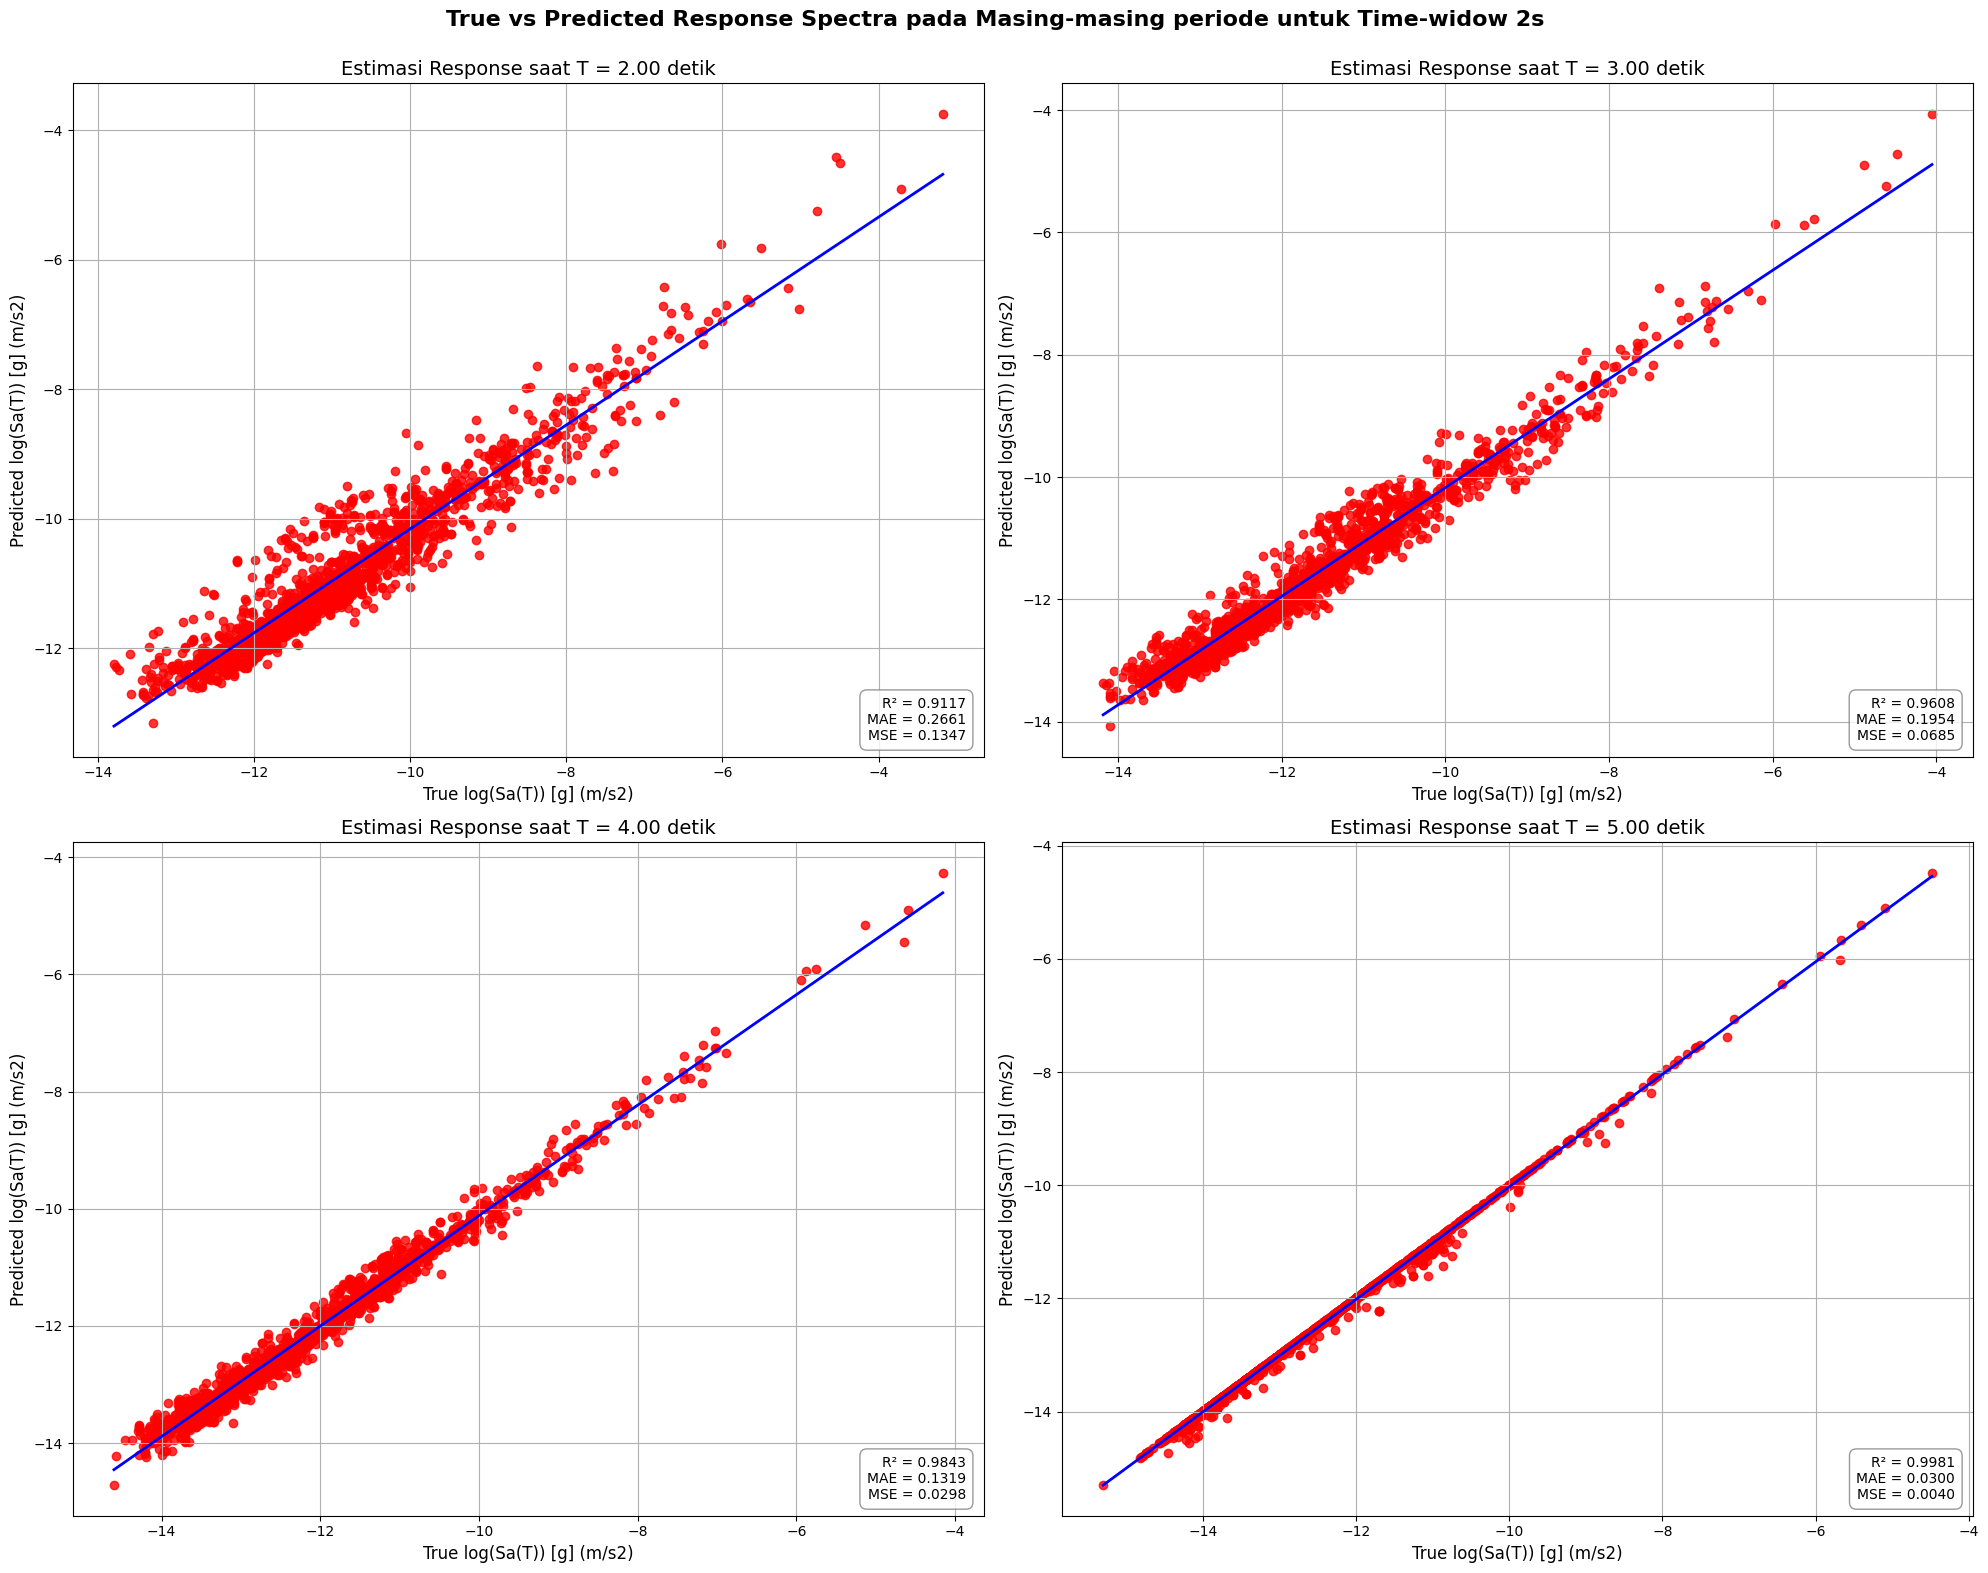

In [10]:
import os
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import backend as K
from preprocessing import SeismicDataGenerator
from vae_model import Sampling, SpectrogramVAE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Clear previous session ===
K.clear_session()
gc.collect()

# === Configuration parameters ===
trim_time = "2s"
batch_size = 16

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
model_folder = os.path.join(base_folder, 'model', 'INSTANCE_model')
evaluation_folder = os.path.join(base_folder, 'evaluation')
hdf5_folder = os.path.join(base_folder, 'spectral_data')
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
saved_model_path = os.path.join(model_folder, f'vae_model_{trim_time}')
test_indices_path = os.path.join(evaluation_folder, 'evaluation_INSTANCE', f'test_indices_{trim_time}.npy')
results_folder = os.path.join(evaluation_folder, 'pga_comparison')
os.makedirs(results_folder, exist_ok=True)

# Load model and data
print("Loading model and data...")
custom_objects = {'Sampling': Sampling, 'SpectrogramVAE': SpectrogramVAE}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(saved_model_path)
test_indices = np.load(test_indices_path)

with h5py.File(hdf5_path, 'r') as f:
    osc_periods = f['osc_periods'][:]
    metadata = f['image_metadata'][:]
    event_ids = [event_id.decode('utf-8') for event_id in metadata['event_id']]
    t2_idx = np.argmin(np.abs(osc_periods - 2.0))
    t3_idx = np.argmin(np.abs(osc_periods - 3.0))
    t4_idx = np.argmin(np.abs(osc_periods - 4.0))
    t5_idx = np.argmin(np.abs(osc_periods - 5.0))

# Create data generator
test_generator = SeismicDataGenerator(
    hdf5_path=hdf5_path, images_folder=images_folder,
    batch_size=batch_size, indices=test_indices,
    shuffle=False, trim_time=trim_time
)

# Process samples
n_test_samples = len(test_indices)
pred_spectra = np.zeros((n_test_samples, len(osc_periods)))
true_spectra = np.zeros((n_test_samples, len(osc_periods)))
pga_values = np.zeros(n_test_samples)

print("Processing samples...")
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    batch_images = x_batch["input_image"]
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_test_samples)

    pred_batch = model.predict(batch_images, verbose=0)
    if isinstance(pred_batch, dict):
        pred_spectra[start_idx:end_idx] = pred_batch["output_spectra"]
    else:
        pred_spectra[start_idx:end_idx] = pred_batch

    true_spectra[start_idx:end_idx] = y_batch["output_spectra"]

    batch_orig_indices = test_indices[start_idx:end_idx]
    for j, idx in enumerate(batch_orig_indices):
        event_id = event_ids[idx]
        with h5py.File(hdf5_path, 'r') as f:
            try:
                pga_values[start_idx + j] = np.log(f[f"{event_id}/metadata"].attrs['PGA (m/s2)'])
            except:
                print(f"Warning: Could not get PGA for {event_id}")
                pga_values[start_idx + j] = np.nan

    if (i + 1) % 5 == 0 or (i + 1) == len(test_generator):
        print(f"Processed {end_idx}/{n_test_samples} samples...")

# Filter NaN
valid_mask = ~np.isnan(pga_values)
pga_values = pga_values[valid_mask]
pred_spectra = pred_spectra[valid_mask]
true_spectra = true_spectra[valid_mask]

# Denormalize
print("Denormalizing predicted spectra...")
with h5py.File(hdf5_path, 'r') as f:
    original_spectra = np.zeros((sum(valid_mask), len(osc_periods)))
    sample_idx = 0
    for i, idx in enumerate(test_indices):
        if i >= len(valid_mask) or not valid_mask[i]:
            continue
        event_id = event_ids[idx]
        try:
            original_spectra[sample_idx] = f[f"{event_id}/response_spectra/spec_accel"][:]
            sample_idx += 1
        except:
            print(f"Warning: Could not get original spectra for {event_id}")

spectra_min = np.min(original_spectra, axis=1, keepdims=True)
spectra_max = np.max(original_spectra, axis=1, keepdims=True)
safe_range = spectra_max - spectra_min
safe_range[safe_range <= 1e-8] = 1.0

pred_spectra_denorm = pred_spectra * safe_range + spectra_min
true_spectra_denorm = true_spectra * safe_range + spectra_min

# Extract values at target periods
pred_t = {
    2.0: pred_spectra_denorm[:, t2_idx],
    3.0:  pred_spectra_denorm[:, t3_idx],
    4.0:  pred_spectra_denorm[:, t4_idx],
    5.0:  pred_spectra_denorm[:, t5_idx],
}
true_t = {
    2.0: true_spectra_denorm[:, t2_idx],
    3.0: true_spectra_denorm[:, t3_idx],
    4.0: true_spectra_denorm[:, t4_idx],
    5.0: true_spectra_denorm[:, t5_idx],
}

# Compute regression + metrics
metrics = {}
for T in [2.0, 3.0, 4.0, 5.0]:
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    metrics[T] = {"slope": slope, "intercept": intercept, "r2": r2, "mae": mae, "mse": mse}

# === Plotting ===
plt.figure(figsize=(20, 16))
plt.suptitle(f"True vs Predicted Response Spectra pada Masing-masing periode untuk Time-widow {trim_time}", fontsize = 16, fontweight="bold")
targets = [2.0, 3.0, 4.0, 5.0]

for i, T in enumerate(targets, 1):
    plt.subplot(2, 2, i)
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = metrics[T]["slope"], metrics[T]["intercept"]

    plt.scatter(x, y, alpha=0.8, color='red')
    x_range = np.linspace(min(x), max(x), 100)
    plt.plot(x_range, slope * x_range + intercept, 'b-', linewidth=2)

    metrics_text = f"R² = {metrics[T]['r2']:.4f}\nMAE = {metrics[T]['mae']:.4f}\nMSE = {metrics[T]['mse']:.4f}"
    plt.annotate(metrics_text, xy=(0.98, 0.02), xycoords='axes fraction',
                 fontsize=10, ha='right', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    xlabel = "True log(Sa(T)) [g] (m/s2)"
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel("Predicted log(Sa(T)) [g] (m/s2)", fontsize = 12)
    plt.title(f"Estimasi Response saat T = {T:.2f} detik", fontsize=14)
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plot_path = os.path.join(results_folder, f"pga_vs_predicted_response_{trim_time}.png")
plt.savefig(plot_path, dpi=600)
print(f"Plot saved to {plot_path}")
print("Analysis complete!")

Loading model and data...
Using image type: trimmed_25s
First few event IDs: ['event_0000', 'event_0001', 'event_0002', 'event_0003', 'event_0004']
First few image paths: ['e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_25s\\event_0000.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_25s\\event_0001.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_25s\\event_0002.png']
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_25s\event_0000.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_25s\event_0001.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fad

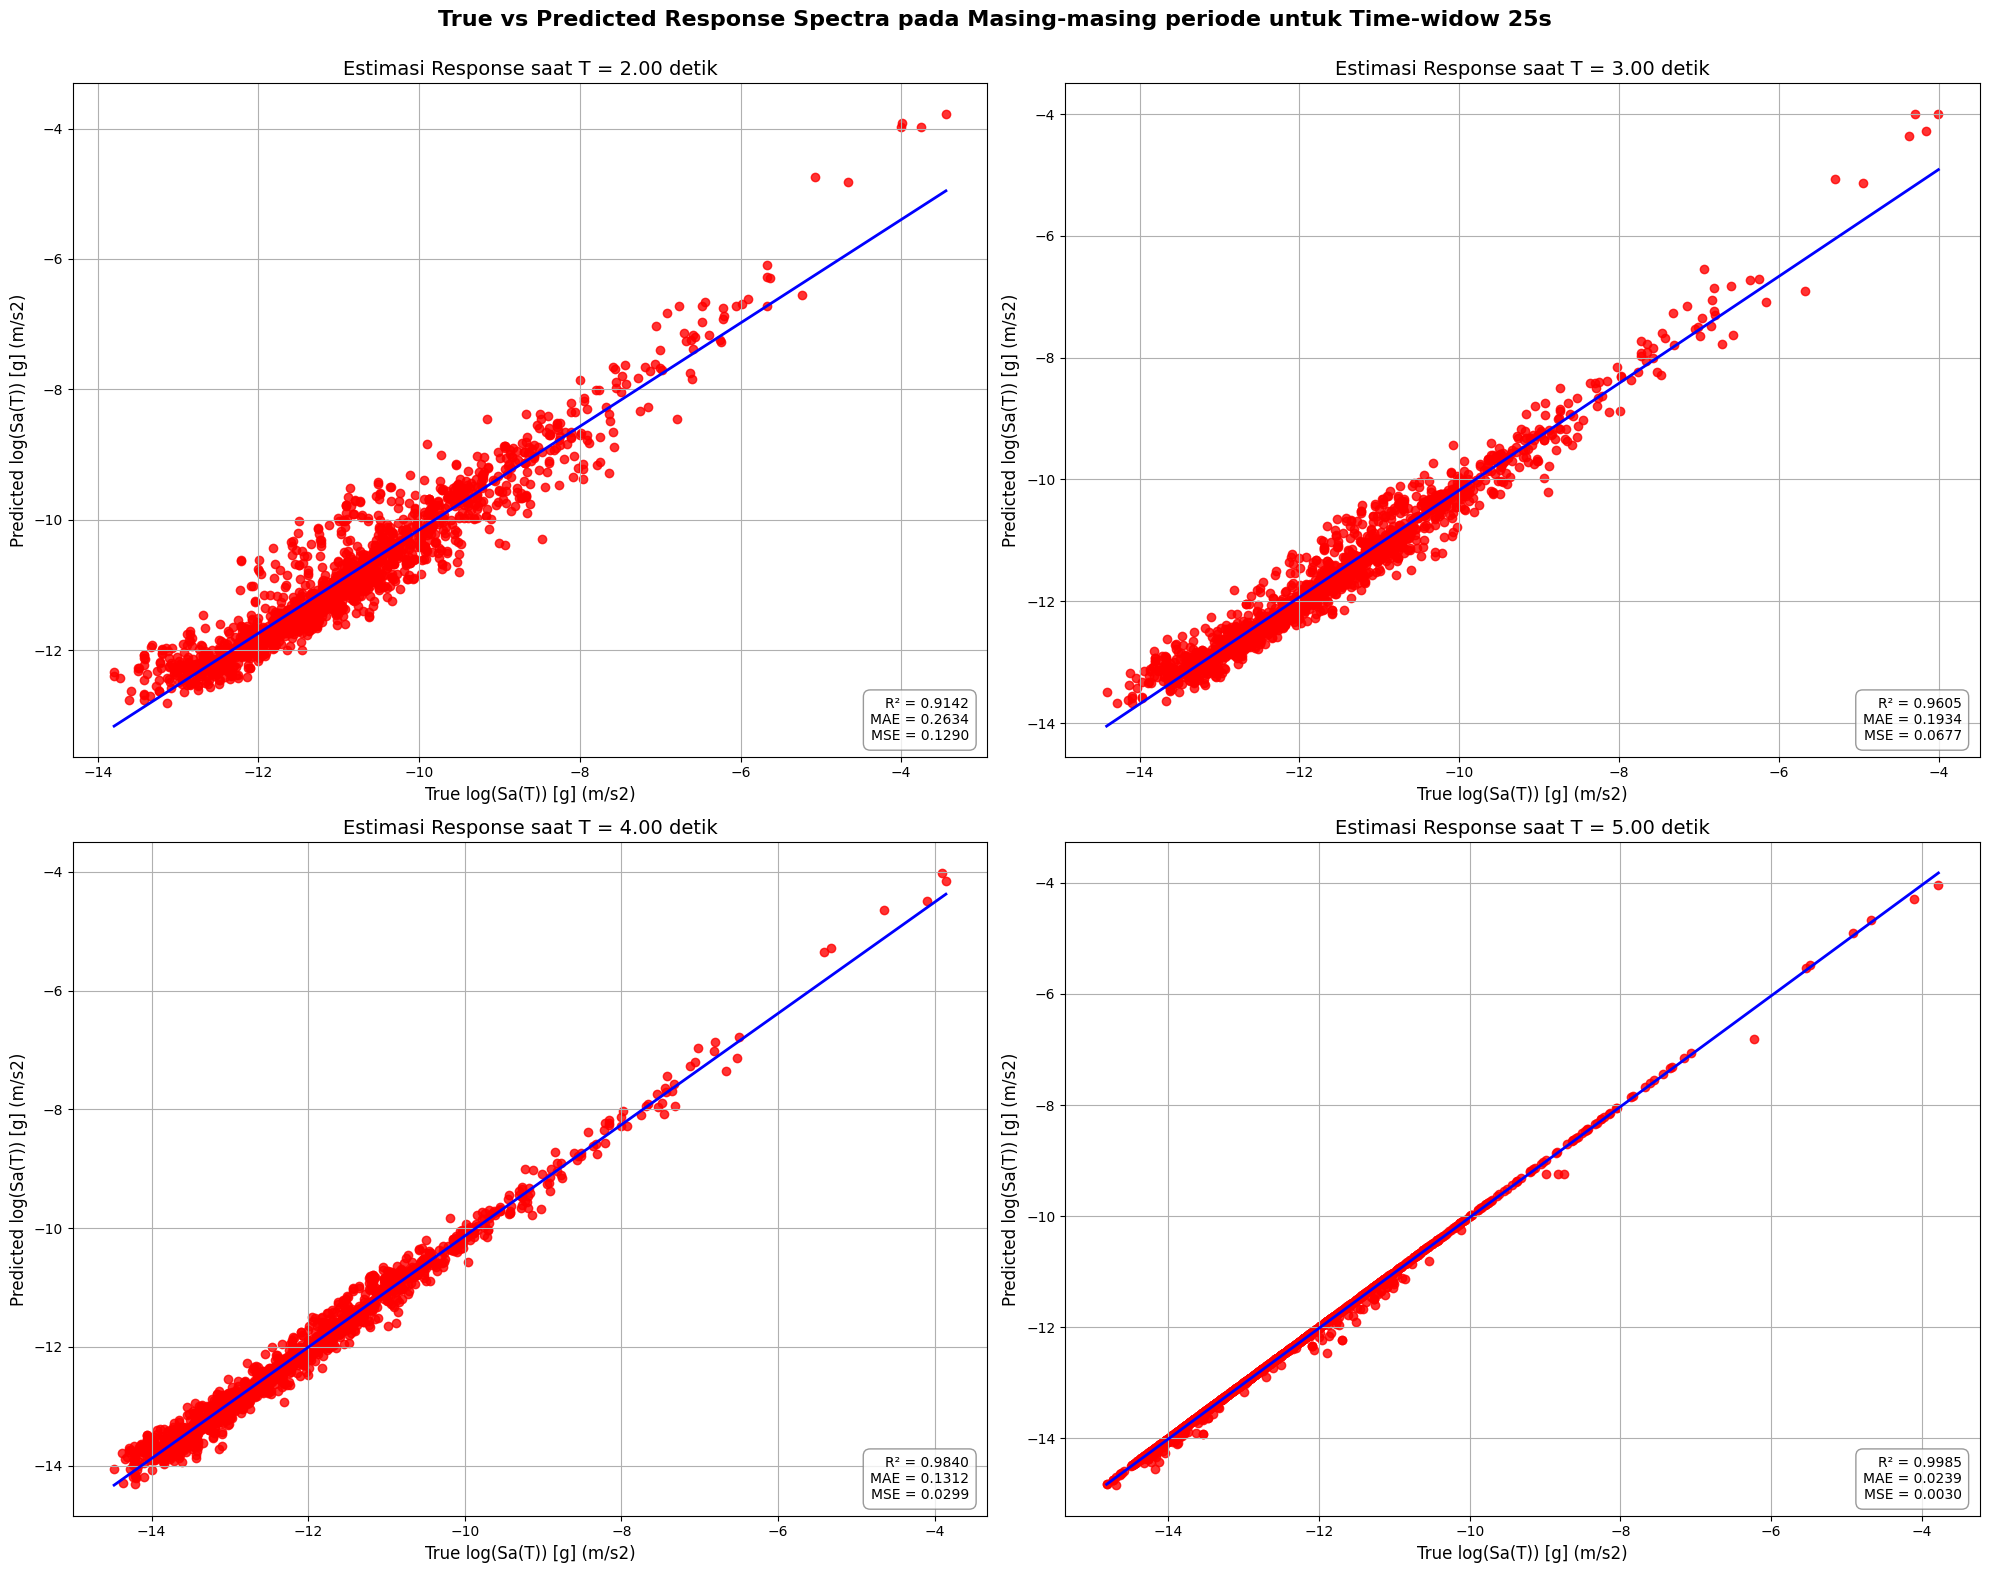

In [11]:
import os
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import backend as K
from preprocessing import SeismicDataGenerator
from vae_model import Sampling, SpectrogramVAE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Clear previous session ===
K.clear_session()
gc.collect()

# === Configuration parameters ===
trim_time = "25s"
batch_size = 16

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
model_folder = os.path.join(base_folder, 'model', 'INSTANCE_model')
evaluation_folder = os.path.join(base_folder, 'evaluation')
hdf5_folder = os.path.join(base_folder, 'spectral_data')
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
saved_model_path = os.path.join(model_folder, f'vae_model_{trim_time}')
test_indices_path = os.path.join(evaluation_folder, 'evaluation_INSTANCE', f'test_indices_{trim_time}.npy')
results_folder = os.path.join(evaluation_folder, 'pga_comparison')
os.makedirs(results_folder, exist_ok=True)

# Load model and data
print("Loading model and data...")
custom_objects = {'Sampling': Sampling, 'SpectrogramVAE': SpectrogramVAE}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(saved_model_path)
test_indices = np.load(test_indices_path)

with h5py.File(hdf5_path, 'r') as f:
    osc_periods = f['osc_periods'][:]
    metadata = f['image_metadata'][:]
    event_ids = [event_id.decode('utf-8') for event_id in metadata['event_id']]
    t2_idx = np.argmin(np.abs(osc_periods - 2.0))
    t3_idx = np.argmin(np.abs(osc_periods - 3.0))
    t4_idx = np.argmin(np.abs(osc_periods - 4.0))
    t5_idx = np.argmin(np.abs(osc_periods - 5.0))

# Create data generator
test_generator = SeismicDataGenerator(
    hdf5_path=hdf5_path, images_folder=images_folder,
    batch_size=batch_size, indices=test_indices,
    shuffle=False, trim_time=trim_time
)

# Process samples
n_test_samples = len(test_indices)
pred_spectra = np.zeros((n_test_samples, len(osc_periods)))
true_spectra = np.zeros((n_test_samples, len(osc_periods)))
pga_values = np.zeros(n_test_samples)

print("Processing samples...")
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    batch_images = x_batch["input_image"]
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_test_samples)

    pred_batch = model.predict(batch_images, verbose=0)
    if isinstance(pred_batch, dict):
        pred_spectra[start_idx:end_idx] = pred_batch["output_spectra"]
    else:
        pred_spectra[start_idx:end_idx] = pred_batch

    true_spectra[start_idx:end_idx] = y_batch["output_spectra"]

    batch_orig_indices = test_indices[start_idx:end_idx]
    for j, idx in enumerate(batch_orig_indices):
        event_id = event_ids[idx]
        with h5py.File(hdf5_path, 'r') as f:
            try:
                pga_values[start_idx + j] = np.log(f[f"{event_id}/metadata"].attrs['PGA (m/s2)'])
            except:
                print(f"Warning: Could not get PGA for {event_id}")
                pga_values[start_idx + j] = np.nan

    if (i + 1) % 5 == 0 or (i + 1) == len(test_generator):
        print(f"Processed {end_idx}/{n_test_samples} samples...")

# Filter NaN
valid_mask = ~np.isnan(pga_values)
pga_values = pga_values[valid_mask]
pred_spectra = pred_spectra[valid_mask]
true_spectra = true_spectra[valid_mask]

# Denormalize
print("Denormalizing predicted spectra...")
with h5py.File(hdf5_path, 'r') as f:
    original_spectra = np.zeros((sum(valid_mask), len(osc_periods)))
    sample_idx = 0
    for i, idx in enumerate(test_indices):
        if i >= len(valid_mask) or not valid_mask[i]:
            continue
        event_id = event_ids[idx]
        try:
            original_spectra[sample_idx] = f[f"{event_id}/response_spectra/spec_accel"][:]
            sample_idx += 1
        except:
            print(f"Warning: Could not get original spectra for {event_id}")

spectra_min = np.min(original_spectra, axis=1, keepdims=True)
spectra_max = np.max(original_spectra, axis=1, keepdims=True)
safe_range = spectra_max - spectra_min
safe_range[safe_range <= 1e-8] = 1.0

pred_spectra_denorm = pred_spectra * safe_range + spectra_min
true_spectra_denorm = true_spectra * safe_range + spectra_min

# Extract values at target periods
pred_t = {
    2.0: pred_spectra_denorm[:, t2_idx],
    3.0:  pred_spectra_denorm[:, t3_idx],
    4.0:  pred_spectra_denorm[:, t4_idx],
    5.0:  pred_spectra_denorm[:, t5_idx],
}
true_t = {
    2.0: true_spectra_denorm[:, t2_idx],
    3.0: true_spectra_denorm[:, t3_idx],
    4.0: true_spectra_denorm[:, t4_idx],
    5.0: true_spectra_denorm[:, t5_idx],
}

# Compute regression + metrics
metrics = {}
for T in [2.0, 3.0, 4.0, 5.0]:
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    metrics[T] = {"slope": slope, "intercept": intercept, "r2": r2, "mae": mae, "mse": mse}

# === Plotting ===
plt.figure(figsize=(20, 16))
plt.suptitle(f"True vs Predicted Response Spectra pada Masing-masing periode untuk Time-widow {trim_time}", fontsize = 16, fontweight="bold")
targets = [2.0, 3.0, 4.0, 5.0]

for i, T in enumerate(targets, 1):
    plt.subplot(2, 2, i)
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = metrics[T]["slope"], metrics[T]["intercept"]

    plt.scatter(x, y, alpha=0.8, color='red')
    x_range = np.linspace(min(x), max(x), 100)
    plt.plot(x_range, slope * x_range + intercept, 'b-', linewidth=2)

    metrics_text = f"R² = {metrics[T]['r2']:.4f}\nMAE = {metrics[T]['mae']:.4f}\nMSE = {metrics[T]['mse']:.4f}"
    plt.annotate(metrics_text, xy=(0.98, 0.02), xycoords='axes fraction',
                 fontsize=10, ha='right', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    xlabel = "True log(Sa(T)) [g] (m/s2)"
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel("Predicted log(Sa(T)) [g] (m/s2)", fontsize = 12)
    plt.title(f"Estimasi Response saat T = {T:.2f} detik", fontsize=14)
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plot_path = os.path.join(results_folder, f"pga_vs_predicted_response_{trim_time}.png")
plt.savefig(plot_path, dpi=600)
print(f"Plot saved to {plot_path}")
print("Analysis complete!")

Loading model and data...
Using image type: trimmed_3s
First few event IDs: ['event_0000', 'event_0001', 'event_0002', 'event_0003', 'event_0004']
First few image paths: ['e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_3s\\event_0000.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_3s\\event_0001.png', 'e:\\Users\\User\\UNIVERSITAS INDONESIA\\BMKG Research 2 - Documents\\2024.EEWS\\Muhammad Fadli\\mel_spectrograms\\trimmed_3s\\event_0002.png']
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_3s\event_0000.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel_spectrograms\trimmed_3s\event_0001.png exists: True
Path e:\Users\User\UNIVERSITAS INDONESIA\BMKG Research 2 - Documents\2024.EEWS\Muhammad Fadli\mel

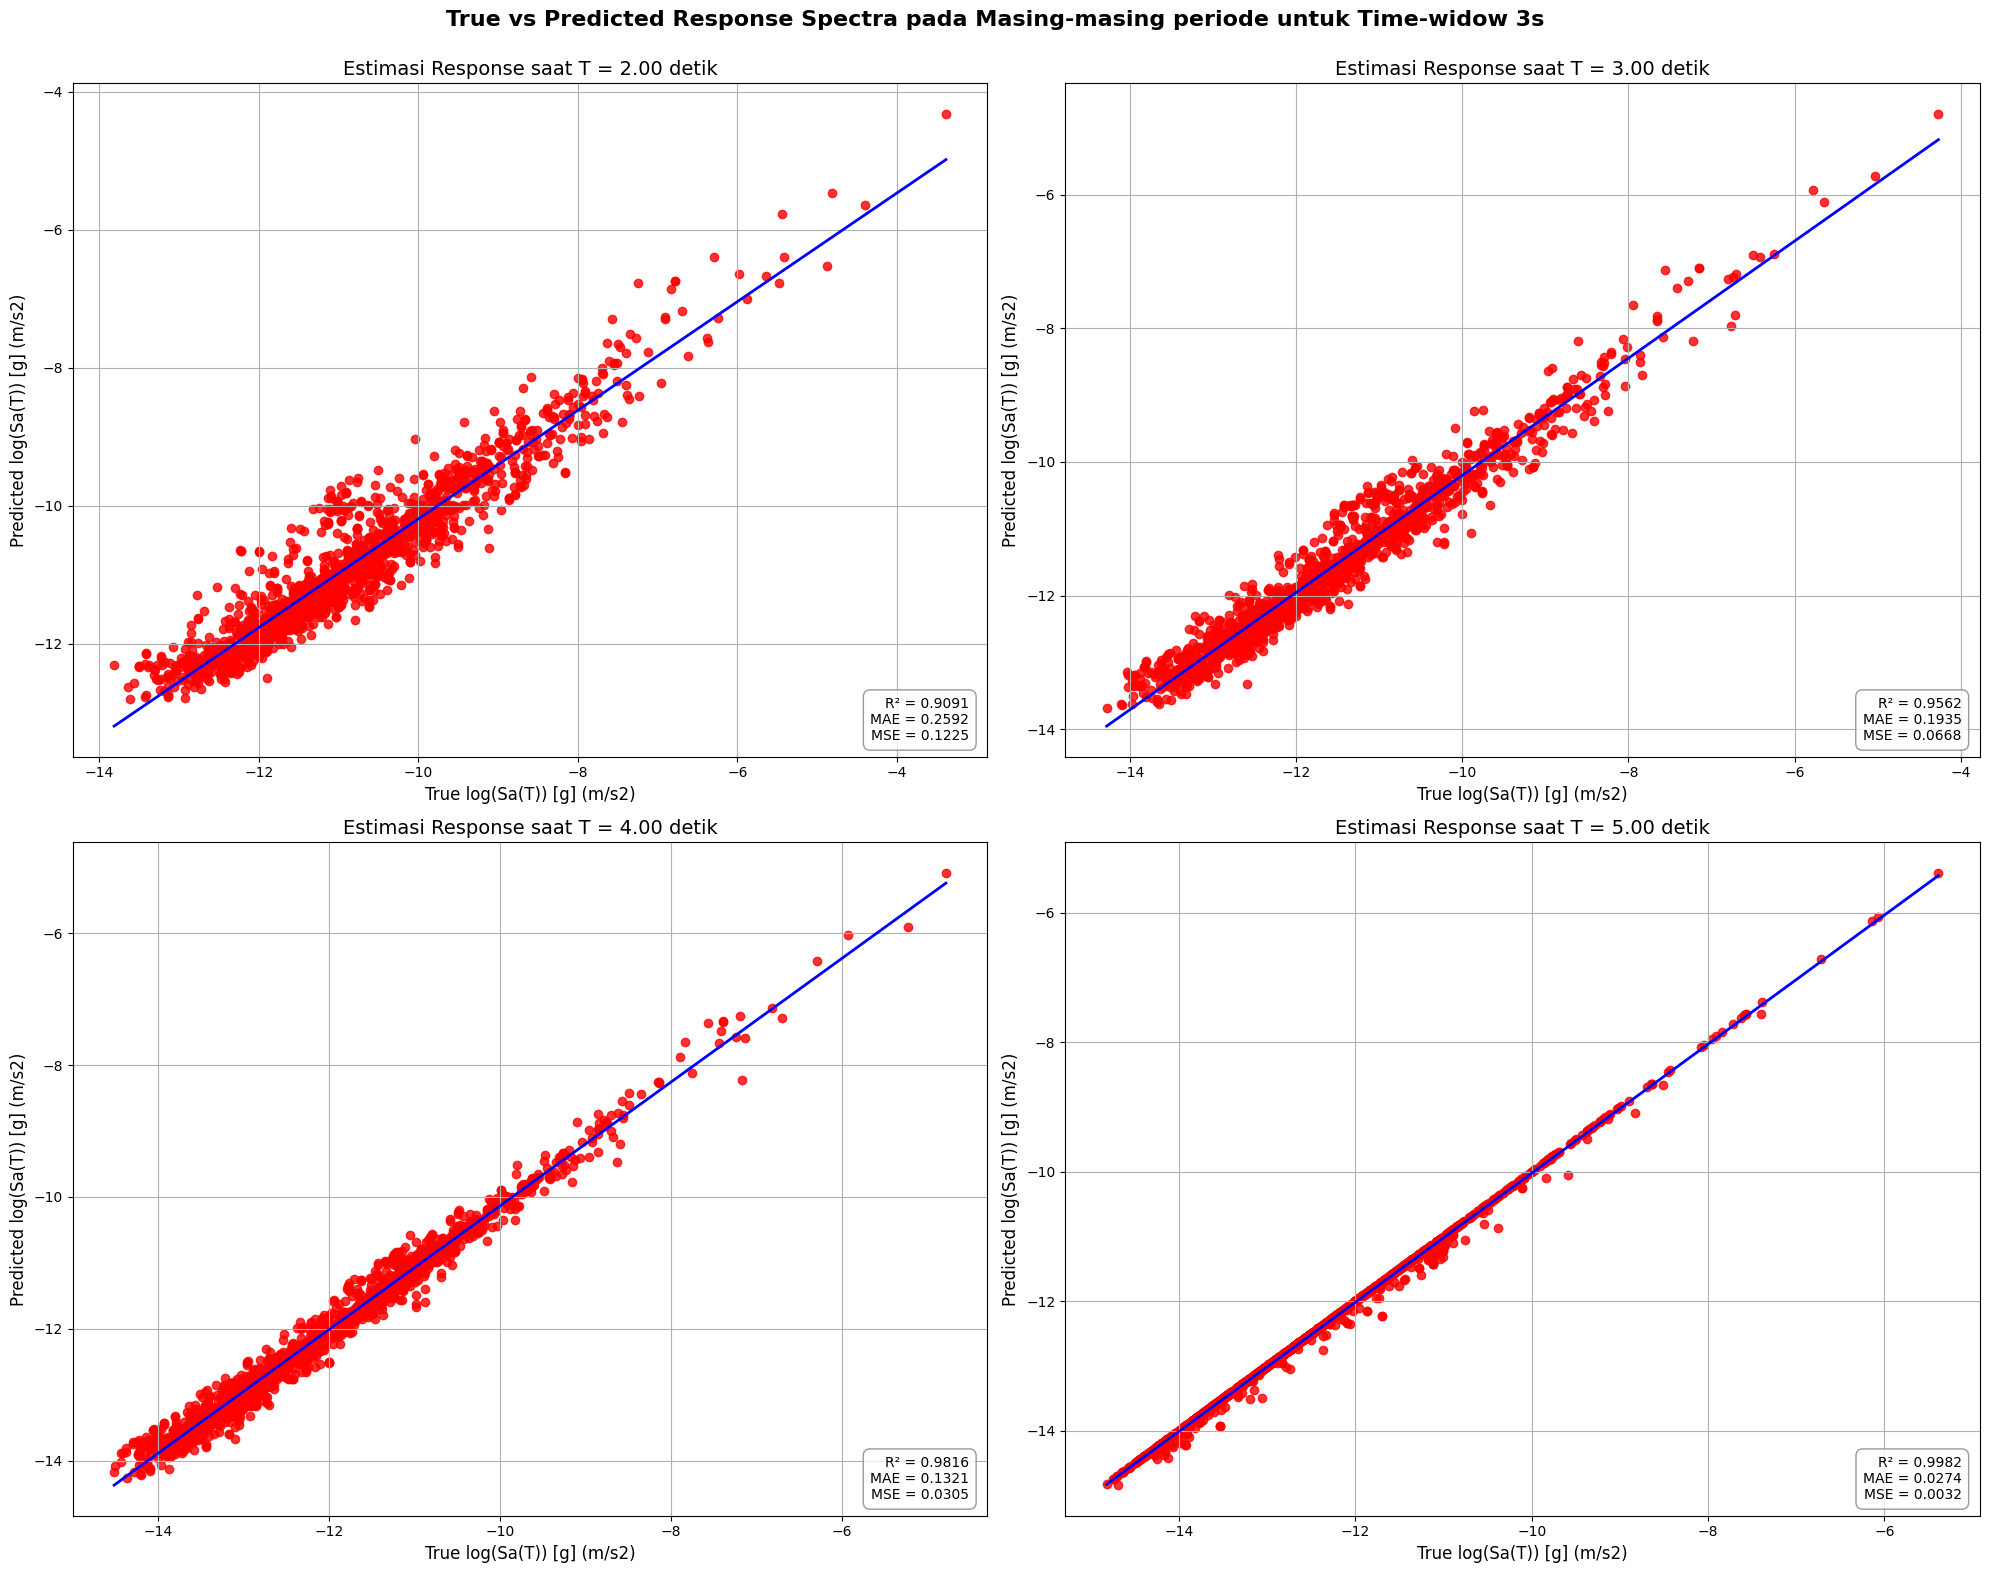

In [12]:
import os
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import backend as K
from preprocessing import SeismicDataGenerator
from vae_model import Sampling, SpectrogramVAE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Clear previous session ===
K.clear_session()
gc.collect()

# === Configuration parameters ===
trim_time = "3s"
batch_size = 16

# Set up paths
base_folder = os.path.join(str(os.getcwd()))
model_folder = os.path.join(base_folder, 'model', 'INSTANCE_model')
evaluation_folder = os.path.join(base_folder, 'evaluation')
hdf5_folder = os.path.join(base_folder, 'spectral_data')
hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')
images_folder = os.path.join(base_folder, 'mel_spectrograms')
saved_model_path = os.path.join(model_folder, f'vae_model_{trim_time}')
test_indices_path = os.path.join(evaluation_folder, 'evaluation_INSTANCE', f'test_indices_{trim_time}.npy')
results_folder = os.path.join(evaluation_folder, 'pga_comparison')
os.makedirs(results_folder, exist_ok=True)

# Load model and data
print("Loading model and data...")
custom_objects = {'Sampling': Sampling, 'SpectrogramVAE': SpectrogramVAE}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(saved_model_path)
test_indices = np.load(test_indices_path)

with h5py.File(hdf5_path, 'r') as f:
    osc_periods = f['osc_periods'][:]
    metadata = f['image_metadata'][:]
    event_ids = [event_id.decode('utf-8') for event_id in metadata['event_id']]
    t2_idx = np.argmin(np.abs(osc_periods - 2.0))
    t3_idx = np.argmin(np.abs(osc_periods - 3.0))
    t4_idx = np.argmin(np.abs(osc_periods - 4.0))
    t5_idx = np.argmin(np.abs(osc_periods - 5.0))

# Create data generator
test_generator = SeismicDataGenerator(
    hdf5_path=hdf5_path, images_folder=images_folder,
    batch_size=batch_size, indices=test_indices,
    shuffle=False, trim_time=trim_time
)

# Process samples
n_test_samples = len(test_indices)
pred_spectra = np.zeros((n_test_samples, len(osc_periods)))
true_spectra = np.zeros((n_test_samples, len(osc_periods)))
pga_values = np.zeros(n_test_samples)

print("Processing samples...")
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    batch_images = x_batch["input_image"]
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_test_samples)

    pred_batch = model.predict(batch_images, verbose=0)
    if isinstance(pred_batch, dict):
        pred_spectra[start_idx:end_idx] = pred_batch["output_spectra"]
    else:
        pred_spectra[start_idx:end_idx] = pred_batch

    true_spectra[start_idx:end_idx] = y_batch["output_spectra"]

    batch_orig_indices = test_indices[start_idx:end_idx]
    for j, idx in enumerate(batch_orig_indices):
        event_id = event_ids[idx]
        with h5py.File(hdf5_path, 'r') as f:
            try:
                pga_values[start_idx + j] = np.log(f[f"{event_id}/metadata"].attrs['PGA (m/s2)'])
            except:
                print(f"Warning: Could not get PGA for {event_id}")
                pga_values[start_idx + j] = np.nan

    if (i + 1) % 5 == 0 or (i + 1) == len(test_generator):
        print(f"Processed {end_idx}/{n_test_samples} samples...")

# Filter NaN
valid_mask = ~np.isnan(pga_values)
pga_values = pga_values[valid_mask]
pred_spectra = pred_spectra[valid_mask]
true_spectra = true_spectra[valid_mask]

# Denormalize
print("Denormalizing predicted spectra...")
with h5py.File(hdf5_path, 'r') as f:
    original_spectra = np.zeros((sum(valid_mask), len(osc_periods)))
    sample_idx = 0
    for i, idx in enumerate(test_indices):
        if i >= len(valid_mask) or not valid_mask[i]:
            continue
        event_id = event_ids[idx]
        try:
            original_spectra[sample_idx] = f[f"{event_id}/response_spectra/spec_accel"][:]
            sample_idx += 1
        except:
            print(f"Warning: Could not get original spectra for {event_id}")

spectra_min = np.min(original_spectra, axis=1, keepdims=True)
spectra_max = np.max(original_spectra, axis=1, keepdims=True)
safe_range = spectra_max - spectra_min
safe_range[safe_range <= 1e-8] = 1.0

pred_spectra_denorm = pred_spectra * safe_range + spectra_min
true_spectra_denorm = true_spectra * safe_range + spectra_min

# Extract values at target periods
pred_t = {
    2.0: pred_spectra_denorm[:, t2_idx],
    3.0:  pred_spectra_denorm[:, t3_idx],
    4.0:  pred_spectra_denorm[:, t4_idx],
    5.0:  pred_spectra_denorm[:, t5_idx],
}
true_t = {
    2.0: true_spectra_denorm[:, t2_idx],
    3.0: true_spectra_denorm[:, t3_idx],
    4.0: true_spectra_denorm[:, t4_idx],
    5.0: true_spectra_denorm[:, t5_idx],
}

# Compute regression + metrics
metrics = {}
for T in [2.0, 3.0, 4.0, 5.0]:
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    metrics[T] = {"slope": slope, "intercept": intercept, "r2": r2, "mae": mae, "mse": mse}

# === Plotting ===
plt.figure(figsize=(20, 16))
plt.suptitle(f"True vs Predicted Response Spectra pada Masing-masing periode untuk Time-widow {trim_time}", fontsize = 16, fontweight="bold")
targets = [2.0, 3.0, 4.0, 5.0]

for i, T in enumerate(targets, 1):
    plt.subplot(2, 2, i)
    x = true_t[T] if T != 0.01 else pga_values
    y = pred_t[T]
    slope, intercept = metrics[T]["slope"], metrics[T]["intercept"]

    plt.scatter(x, y, alpha=0.8, color='red')
    x_range = np.linspace(min(x), max(x), 100)
    plt.plot(x_range, slope * x_range + intercept, 'b-', linewidth=2)

    metrics_text = f"R² = {metrics[T]['r2']:.4f}\nMAE = {metrics[T]['mae']:.4f}\nMSE = {metrics[T]['mse']:.4f}"
    plt.annotate(metrics_text, xy=(0.98, 0.02), xycoords='axes fraction',
                 fontsize=10, ha='right', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    xlabel = "True log(Sa(T)) [g] (m/s2)"
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel("Predicted log(Sa(T)) [g] (m/s2)", fontsize = 12)
    plt.title(f"Estimasi Response saat T = {T:.2f} detik", fontsize=14)
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plot_path = os.path.join(results_folder, f"pga_vs_predicted_response_{trim_time}.png")
plt.savefig(plot_path, dpi=600)
print(f"Plot saved to {plot_path}")
print("Analysis complete!")